# Introduction

This notebook trains a linear discriminant analysis model on preprocessed EEG data to predict behavioral data from neural features.

An example of this can be found in the paper, "Human stereoEEG recordings reveal network dynamics of decision-making in a rule-switching task" by Wal et al.

Behavioral data and preprocessed neural data from Subject 06 in the NCSL EFRI datasetwill be used in this notebook.

## Imports

In [1]:
import h5py 
import mat73
import numpy as np
import pandas as pd
import seaborn as sns
import csv
import mne
from matplotlib import pyplot as plt
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.stats import ttest_1samp

## Load File Paths

In [2]:
# ncsl_share = '/run/user/1000/gvfs/smb-share:server=10.162.37.21,share=main'
# data_path = f'Data/Subject06_snapshot_normalized.npy'
subs = ['06']
file_paths = {}

for sub in subs:
    # create a dictionary holding the file paths
    ncsl_share = '/mnt/ncsl_share'
    file_paths[sub] = {
        'setup_path': ncsl_share + f'/Public/EFRI/1_formatted/SUBJECT{sub}/EFRI{sub}_WAR_SES1_Setup.mat',
        'raw_path': ncsl_share + f'/Public/EFRI/1_formatted/SUBJECT{sub}/EFRI{sub}_WAR_SES1_Raw.mat',
        'data_path': ncsl_share + f'/Daniel/Data/Trial_by_Chan_by_Freq_by_Time_Snapshots/Subject{sub}_snapshot_normalized.npy', # movement onset as event
        # 'data_path' : ncsl_share + f'/Daniel/Data/Trial_by_Chan_by_Freq_by_Time_Snapshots/show-card_pre-2sec_post-4sec/Subject{sub}_snapshot_normalized.npy', # visual cue as event
        'out_path_metrics': f'Metrics/Subject{sub}',
        'out_path_plots': f'Plots/Subject{sub}'
    }

In [3]:
raw_file = h5py.File(file_paths['06']['raw_path'])
setup_data = mat73.loadmat(file_paths['06']['setup_path'])

out_path_plots = file_paths['06']['out_path_plots']
out_path_metrics = file_paths['06']['out_path_metrics']

In [4]:
setup_data.keys()

dict_keys(['elec_area', 'elec_ind', 'elec_name', 'filters', 'trial_times', 'trial_words'])

## Instantiate variables

In [4]:
bets = setup_data['filters']['bets']

good_trials = np.where(np.isnan(bets) == False)[0] # extract indices of trials without the 'nan'

bets = bets[good_trials] # get the bet values for the good trials
subject_cards = setup_data['filters']['card1'][good_trials] # get the subject's card values for the good trials

In [5]:
elec_names = np.array(setup_data['elec_name'])
elec_areas = np.array(setup_data['elec_area'])

In [6]:
data = np.load(file_paths['06']['data_path'])
y = np.asarray([(0 if bet == 5 else 1) for bet in bets]) # 0 = low bet ($5), 1 = high bet ($20)

### Create Frequency Bands

In [7]:
wavelet_freqs = np.logspace(np.log2(2),np.log2(150),num=63,base=2)

frequency_band_indices ={
    "Delta" : [i for i,freq in enumerate(wavelet_freqs) if freq >= 0.5 and freq < 4],
    "Theta" : [i for i,freq in enumerate(wavelet_freqs) if freq >= 4 and freq < 8],
    "Alpha" : [i for i,freq in enumerate(wavelet_freqs) if freq >= 8 and freq < 14],
    "Beta" : [i for i,freq in enumerate(wavelet_freqs) if freq >= 14 and freq < 30],
    "Gamma" : [i for i,freq in enumerate(wavelet_freqs) if freq >= 30]
}

In [8]:
f_band_data = np.zeros((data.shape[0], data.shape[1], 5, data.shape[3]))

for i, key in enumerate(frequency_band_indices):
    f_band_data[:,:,i,:] = data[:,:,frequency_band_indices[key],:].mean(2)

## Model Training

Using the power per wavelet scale for a particular channel and timepoint as a feature. 

In [9]:
def train_LDA_model(data, y, channel, time, time_resolution):
    num_trials, num_channels, num_freqs, num_timesteps = data.shape

    # Checks that inputted value for time resolution is valid
    if not(num_timesteps % time_resolution == 0):
        raise Exception("Invalid time resolution size, num_timesteps % resolution > 0")
    
    X = data[:, channel, :, time:time+time_resolution].mean(2) 

    low_bet_avg_power = X[np.where(y == 0), :][0]
    high_bet_avg_power = X[np.where(y == 1), :][0]
    diff_avg_power = np.abs(high_bet_avg_power.mean(0)) - np.abs(low_bet_avg_power.mean(0))

    # Using RepeatedKFold() for training LDA, but this method does not produce reproducible results! Could possibly average the test scores from all the 5 estimators
    rkf = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)

    estimators = []
    scores = []
    dval = np.zeros(num_trials)

    for train, test in rkf.split(X):
        lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
        lda.fit(X[train], y[train])
        estimators.append(lda)
        scores.append(lda.score(X[test], y[test]))  
        dval[test] = np.dot(X[test], lda.coef_.T).T[0] + lda.intercept_

    lda_coef = estimators[scores.index(max(scores))].coef_[0]

    # Using cross_validate() function for training LDA
    # lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
    # cv_results = cross_validate(lda, X, y, cv = 5, return_estimator=True, return_indices=True) # Possibly pass in a CVSplitter into the cv argument, possibly pass in rkf (?)

    # estimators = cv_results['estimator']
    # scores = cv_results['test_score']

    mean_score = np.mean(scores)
    std_score = np.std(scores)

    # dval = np.dot(X, best_lda.coef_.T).T[0] + best_lda.intercept_ # calculate decision value (!!! mixing training and testing data sets when calculating tval), ensure that every index is only in the test set once

    t_stat = ttest_1samp(dval, popmean=0).statistic # perform 1-sided t-test on decision values corresponding to high bet

    return mean_score, std_score, dval, t_stat, low_bet_avg_power, high_bet_avg_power, diff_avg_power, lda_coef

In [9]:
mean_score, std_score, dval, t_stat, low_bet_avg_power, high_bet_avg_power, lda_coef = train_LDA_model(data,y,0,0,10)

In [10]:
def calculate_LDA_metrics(data, y, time_resolution):
    # Code to train LDA model for all channels and timepoints for Subject 6
    num_trials, num_channels, num_freqs, num_timesteps = data.shape
    rescaled_timesteps = int(num_timesteps/time_resolution)

    # A dictionary that stores all the metrics of the LDA model
    metrics = {
        'Mean Scores' : np.zeros((num_channels, rescaled_timesteps)),
        'STD Scores' : np.zeros((num_channels,rescaled_timesteps)),
        'Decision Values' : np.zeros((num_channels, rescaled_timesteps, num_trials)),
        'T Stats' : np.zeros((num_channels,rescaled_timesteps)),
        'Low Bet Average Powers' : np.zeros((num_channels, rescaled_timesteps, len(y) - int(y.sum()), num_freqs)),
        'High Bet Average Powers' : np.zeros((num_channels, rescaled_timesteps, int(y.sum()), num_freqs)),
        'Difference Bet Average Powers' : np.zeros((num_channels, rescaled_timesteps, num_freqs)),
        'LDA Coefficients' : np.zeros((num_channels, rescaled_timesteps, num_freqs)),
        'Time Resolution' : time_resolution
    }

    for channel in range(num_channels):
        for time in range(rescaled_timesteps):
            metrics['Mean Scores'][channel, time], metrics['STD Scores'][channel, time], metrics['Decision Values'][:, time], metrics['T Stats'][channel, time], metrics['Low Bet Average Powers'][channel, time], metrics['High Bet Average Powers'][channel, time], metrics['Difference Bet Average Powers'][channel, time], metrics['LDA Coefficients'][channel, time] = train_LDA_model(data=data, y=y, channel=channel, time=time*time_resolution, time_resolution=time_resolution)
    
    return metrics

In [11]:
metrics = calculate_LDA_metrics(f_band_data,y,time_resolution=5)

### Save Metrics

In [11]:
with open(out_path_metrics+'_LDA_metrics.csv', 'w', newline="") as fp:
    writer = csv.DictWriter(fp, fieldnames=metrics.keys())
    writer.writeheader()
    writer.writerow(metrics)

### Reshuffling of Data

In [14]:
# Returns an array with shuffled y-values, ensures that high bet ratio is consistent with thay expected for the particular card value

def shuffle_y(y):
    # Get the locations for each particular card value
    card_value_indices = []
    for i in [2,4,6,8,10]:
        card_value_indices.append(np.where(subject_cards == i)[0])

    y_shuffled = np.zeros(y.shape)

    # Ensure that the number of high bets in the shuffled y labels is consistent with the card value
    for indices in card_value_indices:
        temp = indices
        num_high_bets = y[indices].sum() + round(np.random.uniform(-1,1)*y[indices].sum()*0.2) # Get the number of high bets for a particular card value and add some randomness to it
        for j in range(num_high_bets):
            if np.any(temp):
                # Pick a random location from all possible locations of that particular card value and set it to 1 (ie high bet)
                rand = np.random.choice(temp)
                y_shuffled[rand] = 1
                rand_index = np.where(temp == rand)[0]
                temp = np.delete(temp,rand_index) # Remove that location from being able to be chosen again
        y_shuffled[temp] = 0 # set all other locations for that particular card value to 0 (ie low bet)

    return y_shuffled

In [15]:
def get_shuffled_t_stats(data, y, time_resolution):
  np.random.seed()
  y_shuffled = shuffle_y(y)
  metrics = calculate_LDA_metrics(data=data, y=y_shuffled, time_resolution=time_resolution)
    
  return metrics['T Stats']

## Multiprocessing

In [ ]:
from multiprocessing import Pool

n_processes = 3

if __name__ == '__main__':
    with Pool(n_processes) as p:
        results = p.starmap(get_shuffled_t_stats, [(data, y)] * 3)
        p.close()

In [ ]:
import multiprocessing
n_processes = 3
pool = multiprocessing.Pool(processes= n_processes)
results = pool.starmap(get_shuffled_t_stats, [(data, y)] * 2)
pool.close()

In [10]:
sub6_shuffled_t_stats = np.load('t_values/Subject06_shuffled_tvalues.npy')

In [11]:
sub6_shuffled_t_stats.shape

(100, 133, 100)

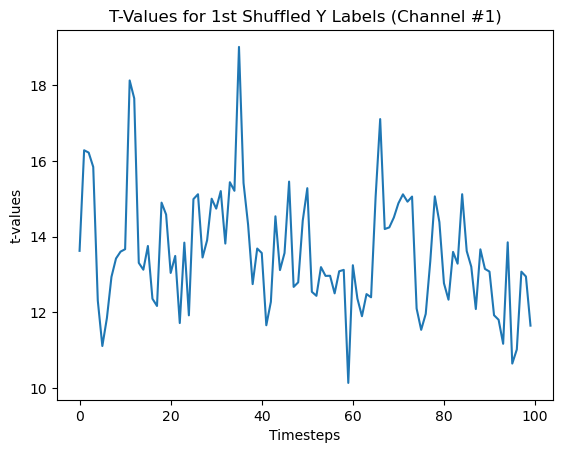

In [12]:
plt.plot(sub6_shuffled_t_stats[0][0])
plt.xlabel('Timesteps')
plt.ylabel('t-values')
plt.title('T-Values for 1st Shuffled Y Labels (Channel #1)')
plt.show()

In [13]:
sub6_t_stats = np.load('t_values/Subject06_tvalues.npy')

In [11]:
sub6_t_stats.shape

(133, 100)

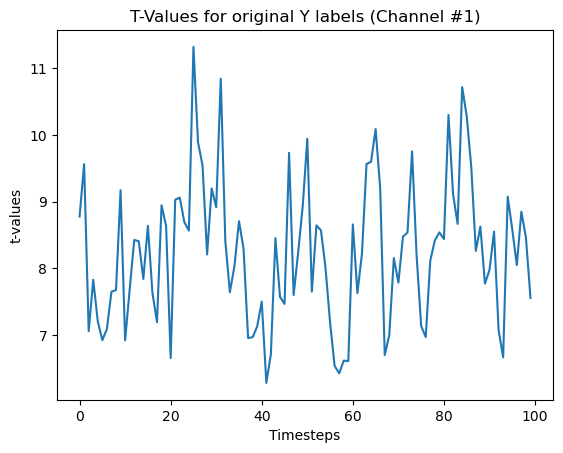

In [15]:
plt.plot(sub6_t_stats[0])
plt.xlabel('Timesteps')
plt.ylabel('t-values')
plt.title('T-Values for original Y labels (Channel #1)')
plt.show()

# Visualization of the Accuracy of the Models

In [14]:
def sort_scores(data, metrics, elec_names, elec_areas, filter_channels):
    num_channels = data.shape[1]
    mean_scores_max = np.zeros((num_channels,3))

    for channel in range(num_channels):
        mean_scores_max[channel, 0] = int(channel) # store the channel index
        mean_scores_max[channel, 1] = list(metrics['Mean Scores'][channel]).index(max(metrics['Mean Scores'][channel])) # the time point at which the maximum mean score occurs
        mean_scores_max[channel, 2] = max(metrics['Mean Scores'][channel]) # value of the maximum mean score in a particular channel for all time points

    if filter_channels == True:
        elec_areas_filtered_idx = [i for i,ea in enumerate(elec_areas) if ea not in ['white matter','CZ','PZ', 'out','FZ','cerebrospinal fluid','lesion L','ventricle L','ventricle R']]
        sorted_indices = mean_scores_max[elec_areas_filtered_idx,2].argsort()[::-1]
        mean_scores_max_sorted = mean_scores_max[elec_areas_filtered_idx][sorted_indices]
        elec_names_sorted = elec_names[np.int_(mean_scores_max_sorted[:, 0])]
        elec_areas_sorted = elec_areas[np.int_(mean_scores_max_sorted[:, 0])]
        
    else:
        sorted_indices = mean_scores_max[:,2].argsort()[::-1]
        mean_scores_max_sorted = mean_scores_max[sorted_indices]
        elec_names_sorted = elec_names[sorted_indices]
        elec_areas_sorted = elec_areas[sorted_indices]

    return mean_scores_max_sorted, elec_names_sorted, elec_areas_sorted

In [15]:
def plot_sorted_scores(metrics, mean_scores_max_sorted, elec_areas, out_path):
    num_channels = len(mean_scores_max_sorted)
    
    fig, axs = plt.subplots(3, 1, figsize=(24,18), gridspec_kw={'height_ratios' : [1,1,1]})

    axs[0].set_title('Sorted Peak Score of LDA Models (from greatest to least)')
    axs[0].set_ylabel('Peak Mean Accuracy')
    axs[0].set_xlabel('Channels (from most to least accurate)')
    axs[0].plot(np.arange(0,num_channels,1), mean_scores_max_sorted[:,2])

    axs[1].set_title('Scatter Plot of Peak Score of LDA Models (from greatest to least) with error bars')
    axs[1].set_ylabel('Peak Mean Accuracy')
    axs[1].set_xlabel('Channels (from most to least accurate)')
    axs[1].scatter(np.arange(0,num_channels,1), mean_scores_max_sorted[:,2])
    axs[1].errorbar(np.arange(0,num_channels,1), mean_scores_max_sorted[:,2], yerr=metrics['STD Scores'][np.int_(mean_scores_max_sorted[:,0]),np.int_(mean_scores_max_sorted[:,1])], fmt="o")
    
    axs[2].set_title('Time of Peak Score of LDA Models')
    axs[2].set_ylabel('Time (seconds)')
    axs[2].set_xlabel('Channels (from most to least accurate)')
    time = mean_scores_max_sorted[:,1]/(20/metrics['Time Resolution']) - 3
    axs[2].scatter(np.arange(0, num_channels), time)
    axs[2].axhline(y = 0, color = 'red', alpha=0.5)

    fig.tight_layout()
    fig.savefig(out_path + f'_sorted_scores')
    
    plt.figure(figsize=(24,24))
    plt.title('Sorted Peak Score of LDA Models (from greatest to least)')
    plt.ylabel('Channel Names')
    plt.xlabel('Score')
    plt.hlines(y=np.arange(0,num_channels), xmin=0.5, xmax=mean_scores_max_sorted[:,2][::-1],
        color='blue', alpha=0.6, linewidth=2)
    plt.yticks(np.arange(0,num_channels), labels=elec_areas[::-1])

    plt.savefig(out_path + f'_sorted_scores_hline')
    

In [135]:
mean_scores_max_sorted, elec_names_sorted, elec_areas_sorted = sort_scores(data, metrics, elec_names, elec_areas, True)

/tmp/ipykernel_162223/440833363.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


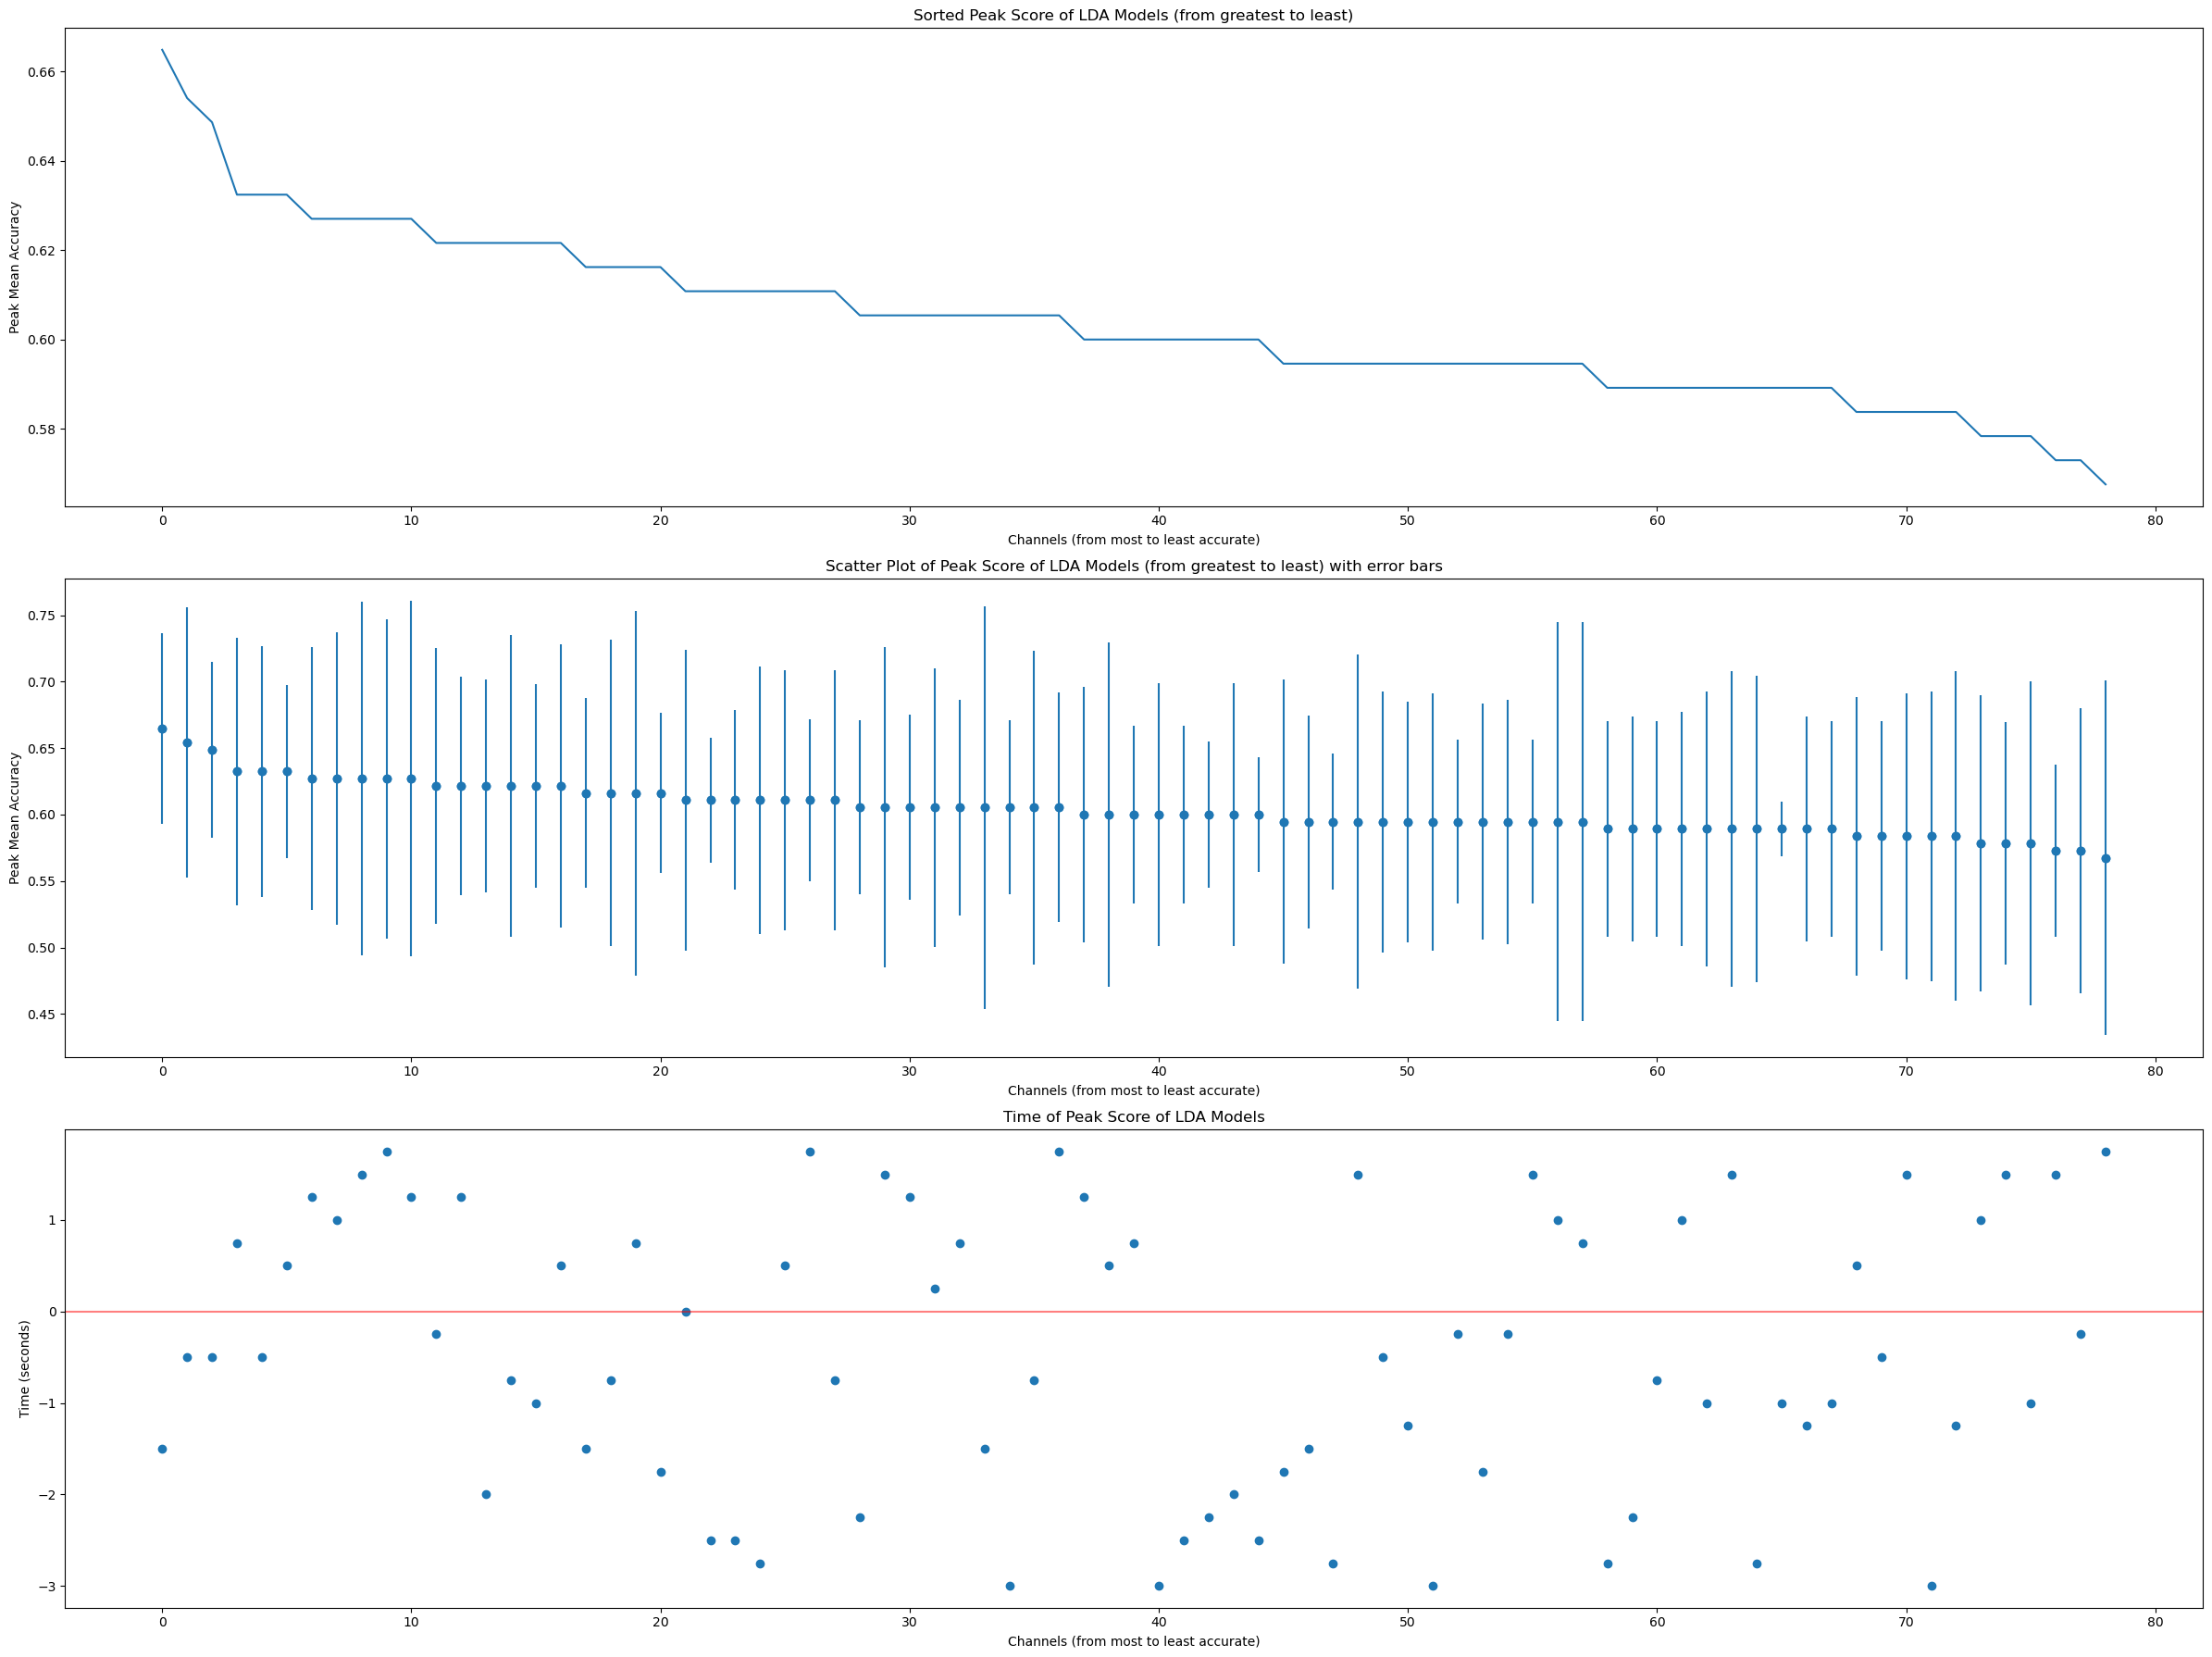

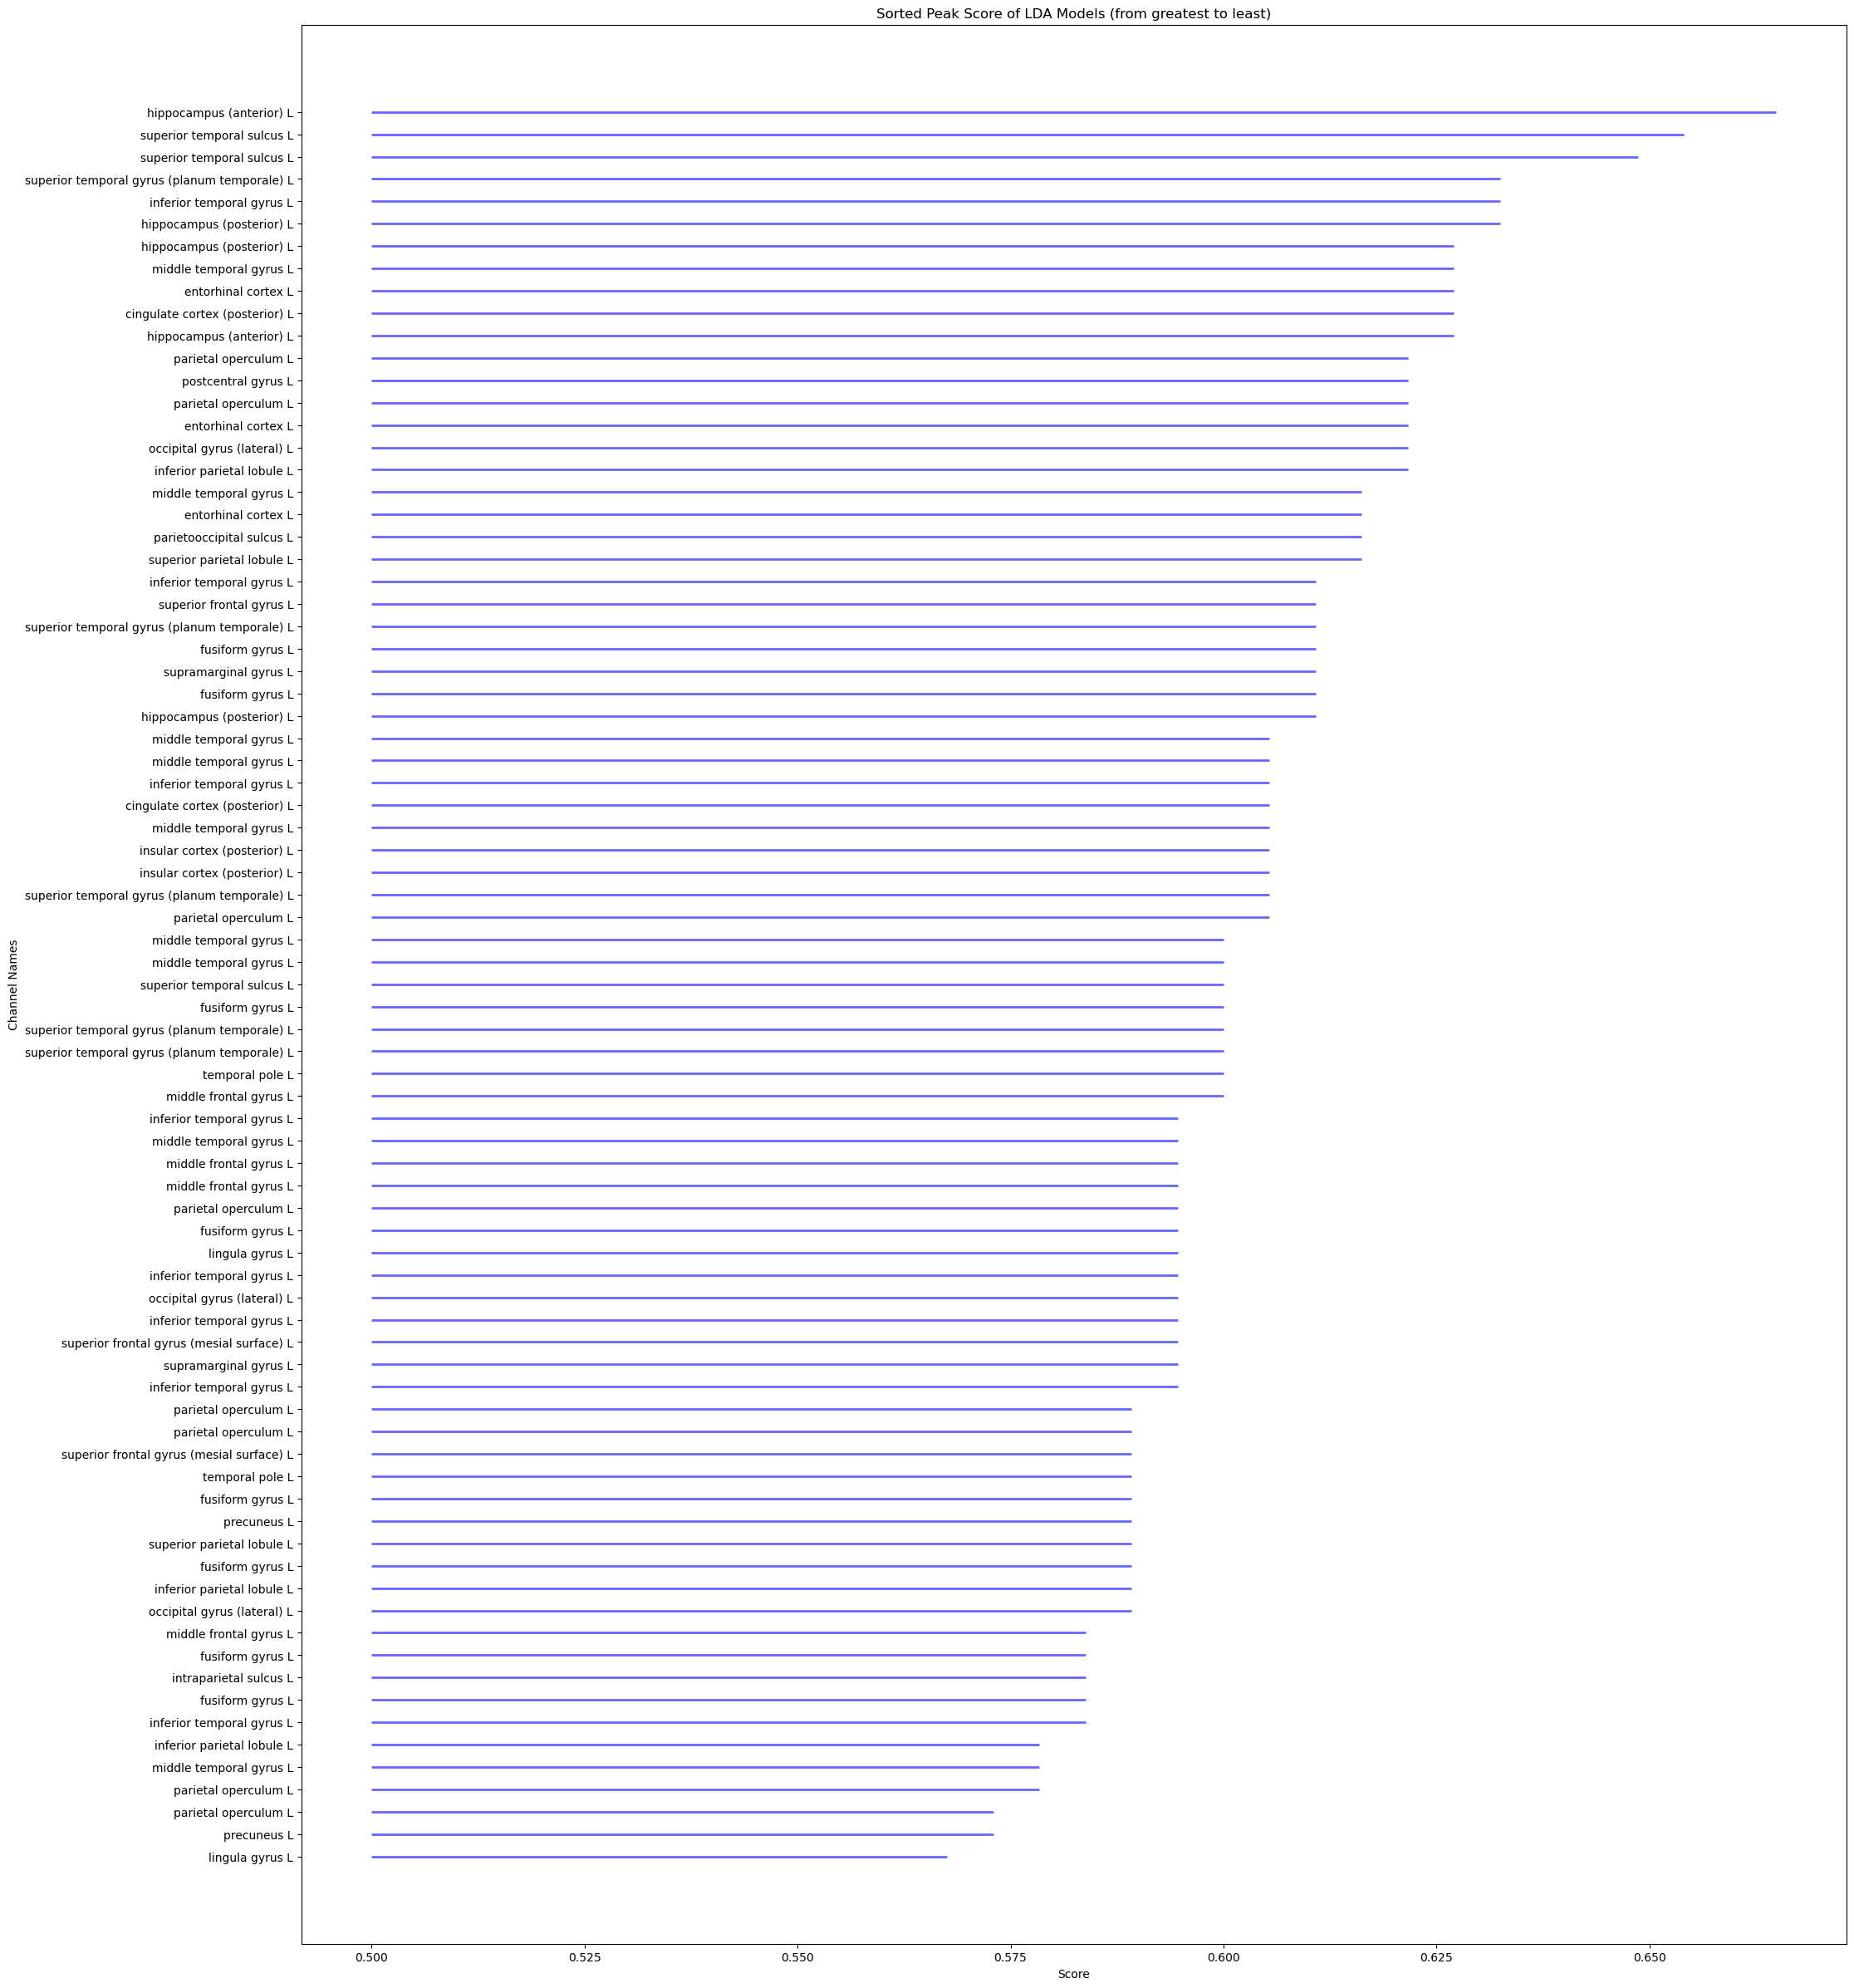

In [140]:
plot_sorted_scores(metrics, mean_scores_max_sorted, elec_areas_sorted, out_path_plots)

In [13]:
# Plots the model accuracy as a function of time for the top performing channels, number of plots specified by "num_plots"
def plot_sorted_scores_per_channel(data, metrics, mean_scores_max_sorted, num_plots, elec_names, elec_areas, out_path):
    num_timesteps = data.shape[3] # NOTE that data isn't actually passed into the function...

    time_resolution = metrics['Time Resolution']
    rescaled_timesteps = int(num_timesteps/time_resolution)
    times = (np.arange(0, rescaled_timesteps, 1) / (20/time_resolution)) - 3 # time 0 seconds denotes when the subject starts moving (i.e. 3 seconds into the data)

    fig, axs = plt.subplots(num_plots, 1, figsize=(24, 6 * num_plots))
    
    for i, trial_data in enumerate(mean_scores_max_sorted[:num_plots]):
        channel, time, peak_accuracy = trial_data
        time = time/(20/time_resolution) - 3
        ax = axs[i]
        ax.plot(times[:], metrics['Mean Scores'][int(channel)])
        ax.set_title('Electrode %s in the %s' %(elec_names[i], elec_areas[i]))
        ax.set_ylabel('Score')
        ax.set_xlabel('Time (seconds)')
        ax.axvspan(time - .0025 ,time + .0025, color = 'red', alpha=0.5)
        ax.annotate(f'(Time: {time:.2f}s, Score: {peak_accuracy:.2f})', xy=(time + .05 ,.6))
    
    plt.savefig(out_path + f'_sorted_scores_per_channel')
    plt.show()

In [26]:
def plot_power_heatmap(data, metrics, mean_scores_max_sorted, num_plots, elec_names, elec_areas, out_path):
    num_freqs, num_timesteps = data.shape[2:]
    time_resolution = metrics['Time Resolution']
    rescaled_timesteps = int(num_timesteps/time_resolution)

    if rescaled_timesteps >= 50:
        num_ticks = int(rescaled_timesteps/2)
    else:
        num_ticks = rescaled_timesteps

    xticks = np.linspace(0, rescaled_timesteps - 1, num=num_ticks, dtype=np.int_)
    xticklabels = np.around(np.linspace(0, rescaled_timesteps - 1, num=num_ticks, dtype=np.int_)/(20/time_resolution) - 3, decimals=2)

    # yticks = np.linspace(0, num_freqs, 10)
    # yticklabels = np.logspace(np.log2(2),np.log2(150),num=num_y_ticks,base=2, dtype=np.int_)

    # y-tick labels for EEG frequency bands
    yticklabels = ["Delta", "Theta", "Alpha", "Beta", "Gamma"]

    for i, trial_data in enumerate(mean_scores_max_sorted[:num_plots]):
        channel, time, peak_accuracy = trial_data

        low_bet_powers = metrics['Low Bet Average Powers'][int(channel), int(time)]
        high_bet_powers = metrics['High Bet Average Powers'][int(channel), int(time)]
        diff_bet_powers = metrics['Difference Bet Average Powers'][int(channel)]
        lda_coef = metrics['LDA Coefficients'][int(channel)]

        fig, axs = plt.subplots(2,2,figsize=(24, 16))
        sns.heatmap(low_bet_powers.T, ax=axs[0][0], vmin=-3, vmax=3, cbar_kws={"label": "Frequency Power"}, cmap="PiYG")
        axs[0][0].set_title('Electrode %s in the %s at time %s \n Low Bet Frequency Power' %(elec_names[i], elec_areas[i], round(time/(20/time_resolution) - 3,2)))
        axs[0][0].set(xlabel="Trial Indices", ylabel="Frequency (Hz)")

        sns.heatmap(high_bet_powers.T, ax=axs[0][1], vmin=-3, vmax=3, cbar_kws={"label": "Frequency Power"}, cmap="PiYG")
        axs[0][1].set_title('Electrode %s in the %s at time %s \n High Bet Frequency Power' %(elec_names[i], elec_areas[i], round(time/(20/time_resolution) - 3,2)))
        axs[0][1].set(xlabel="Trial Indices", ylabel="Frequency (Hz)")

        sns.heatmap(diff_bet_powers.T, ax=axs[1][0], vmin=-.4, vmax=.4, cbar_kws={"label": "Frequency Power"}, cmap="PiYG")
        axs[1][0].set_title('Difference in average power per frequency for high and low bets \n at %s in %s' %(elec_names[i], elec_areas[i]))
        axs[1][0].set(xlabel="Time (sec)", ylabel="Frequency (Hz)")
        axs[1][0].set_xticks(xticks, labels = xticklabels)
        ax = axs[1][0].twinx()
        sns.lineplot(x=np.arange(0,rescaled_timesteps), y=metrics['Mean Scores'][int(channel)], color='blue', ax=ax)
        ax.set_ylabel('Score')

        sns.heatmap(lda_coef.T, ax=axs[1][1], vmin=-1, vmax=1, cbar_kws={"label": "Frequency Power"}, cmap="PiYG")
        axs[1][1].set_title('LDA coefficient values for all frequencies \n at %s in %s' %(elec_names[i], elec_areas[i]))
        axs[1][1].set(xlabel="Time (sec)", ylabel="Frequency (Hz)")
        axs[1][1].set_xticks(xticks, labels = xticklabels)

        for axs_ in axs:
            for ax in axs_:
                ax.axes.invert_yaxis()
                # ax.set_xticks(xticks)
                # ax.set_xticklabels(xticklabels)
                # ax.set_yticks(yticks)
                ax.set_yticklabels(yticklabels)
        
        plt.savefig(out_path + f'_heatmap_{i}')
        plt.show()

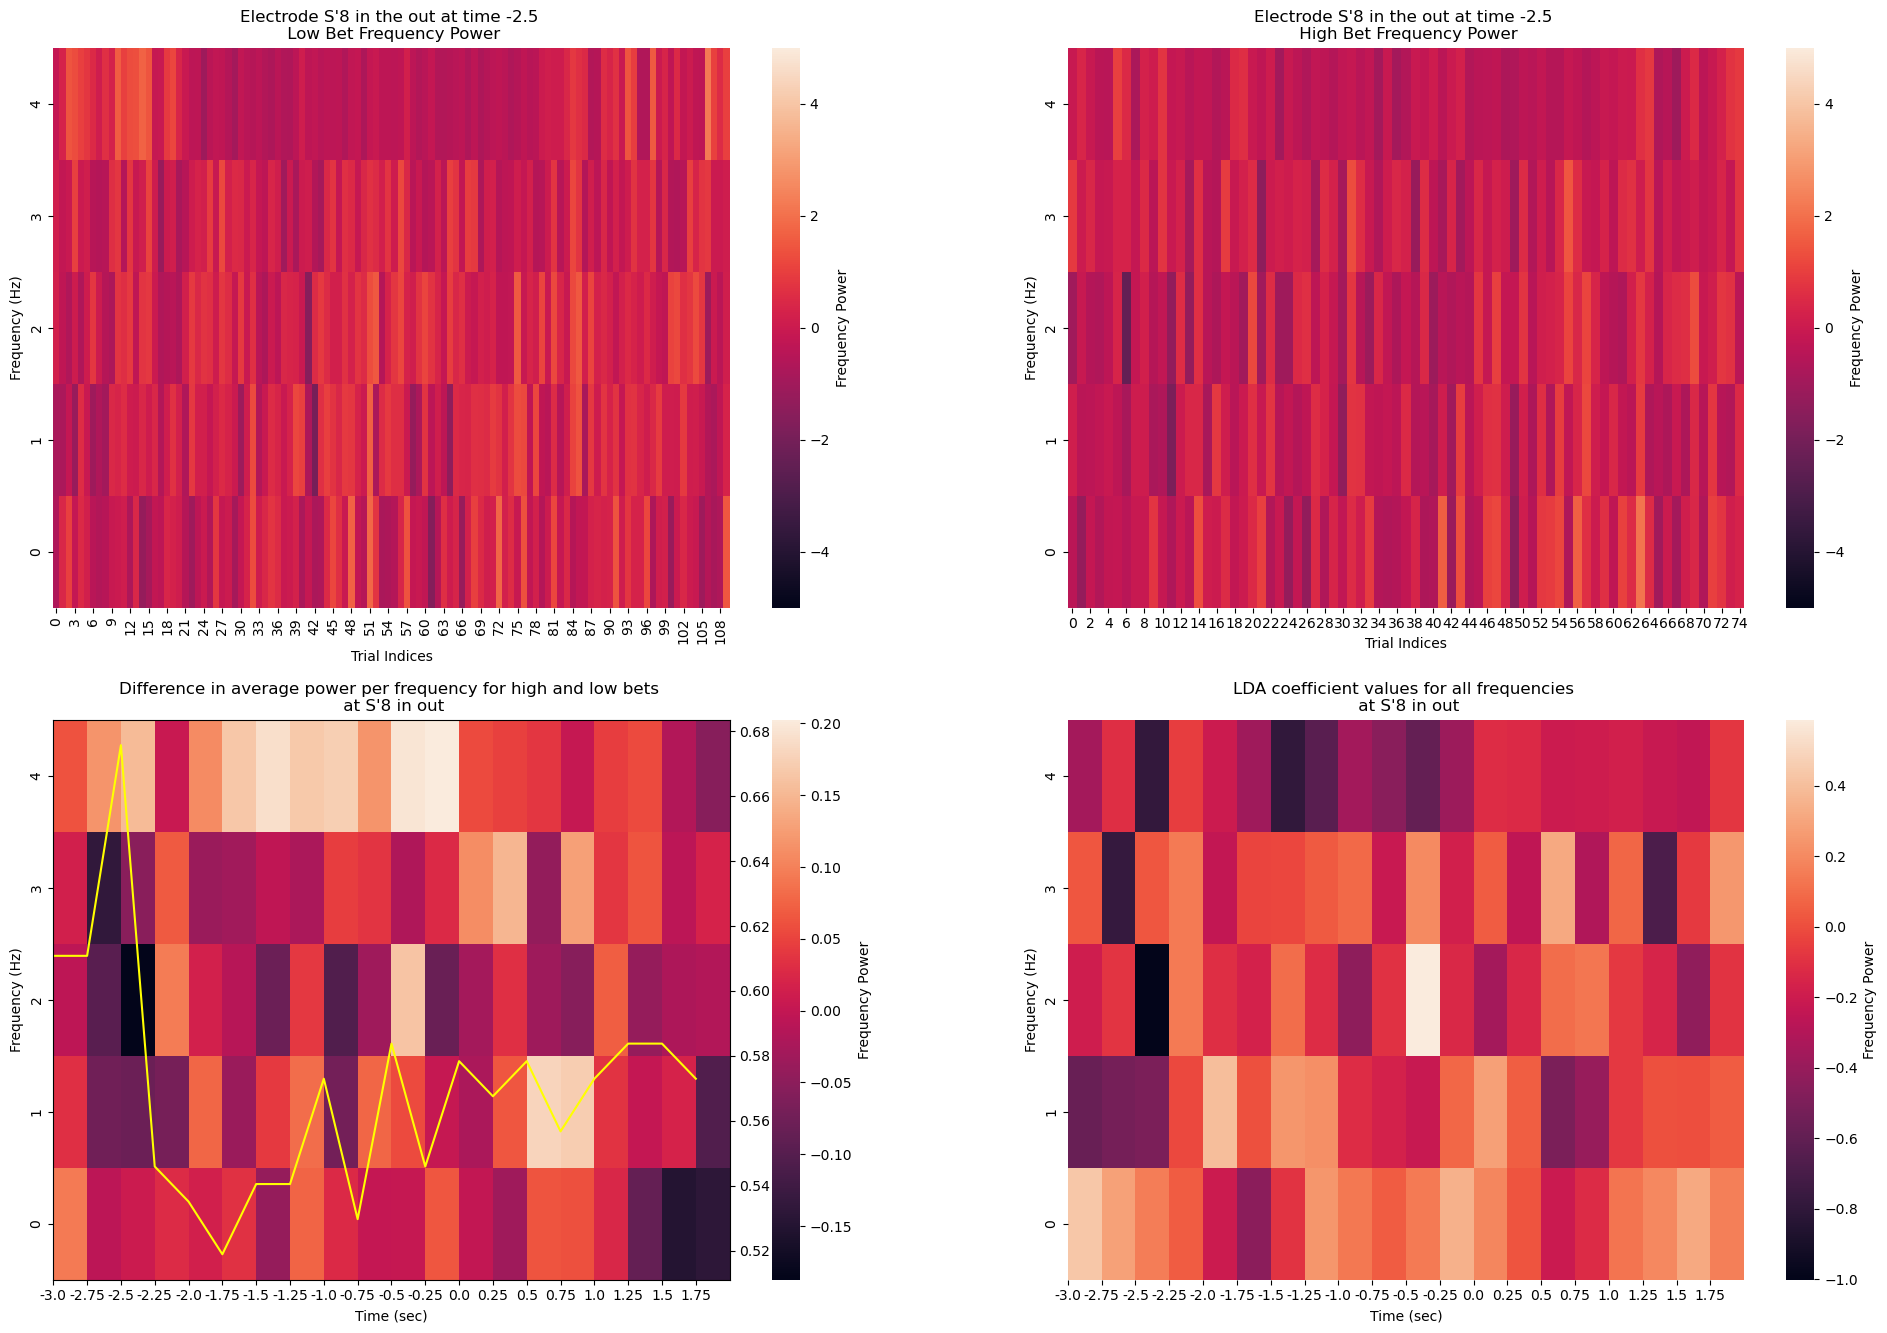

In [104]:
plot_power_heatmap(f_band_data,metrics, mean_scores_max_sorted, 1, elec_names_sorted,elec_areas_sorted,out_path_plots)

In [27]:
def plot_scores(data, metrics, elec_names, elec_areas, num_channels = 10, filter_channels = False, out_path_plots = None):    
    mean_scores_max_sorted, elec_names_sorted, elec_areas_sorted = sort_scores(data, metrics, elec_names, elec_areas, filter_channels)
    plot_sorted_scores(metrics, mean_scores_max_sorted, elec_areas_sorted, out_path_plots)
    plot_sorted_scores_per_channel(data, metrics, mean_scores_max_sorted, num_channels, elec_names_sorted, elec_areas_sorted, out_path_plots)
    plot_power_heatmap(data, metrics, mean_scores_max_sorted, num_channels, elec_names_sorted, elec_areas_sorted, out_path_plots)

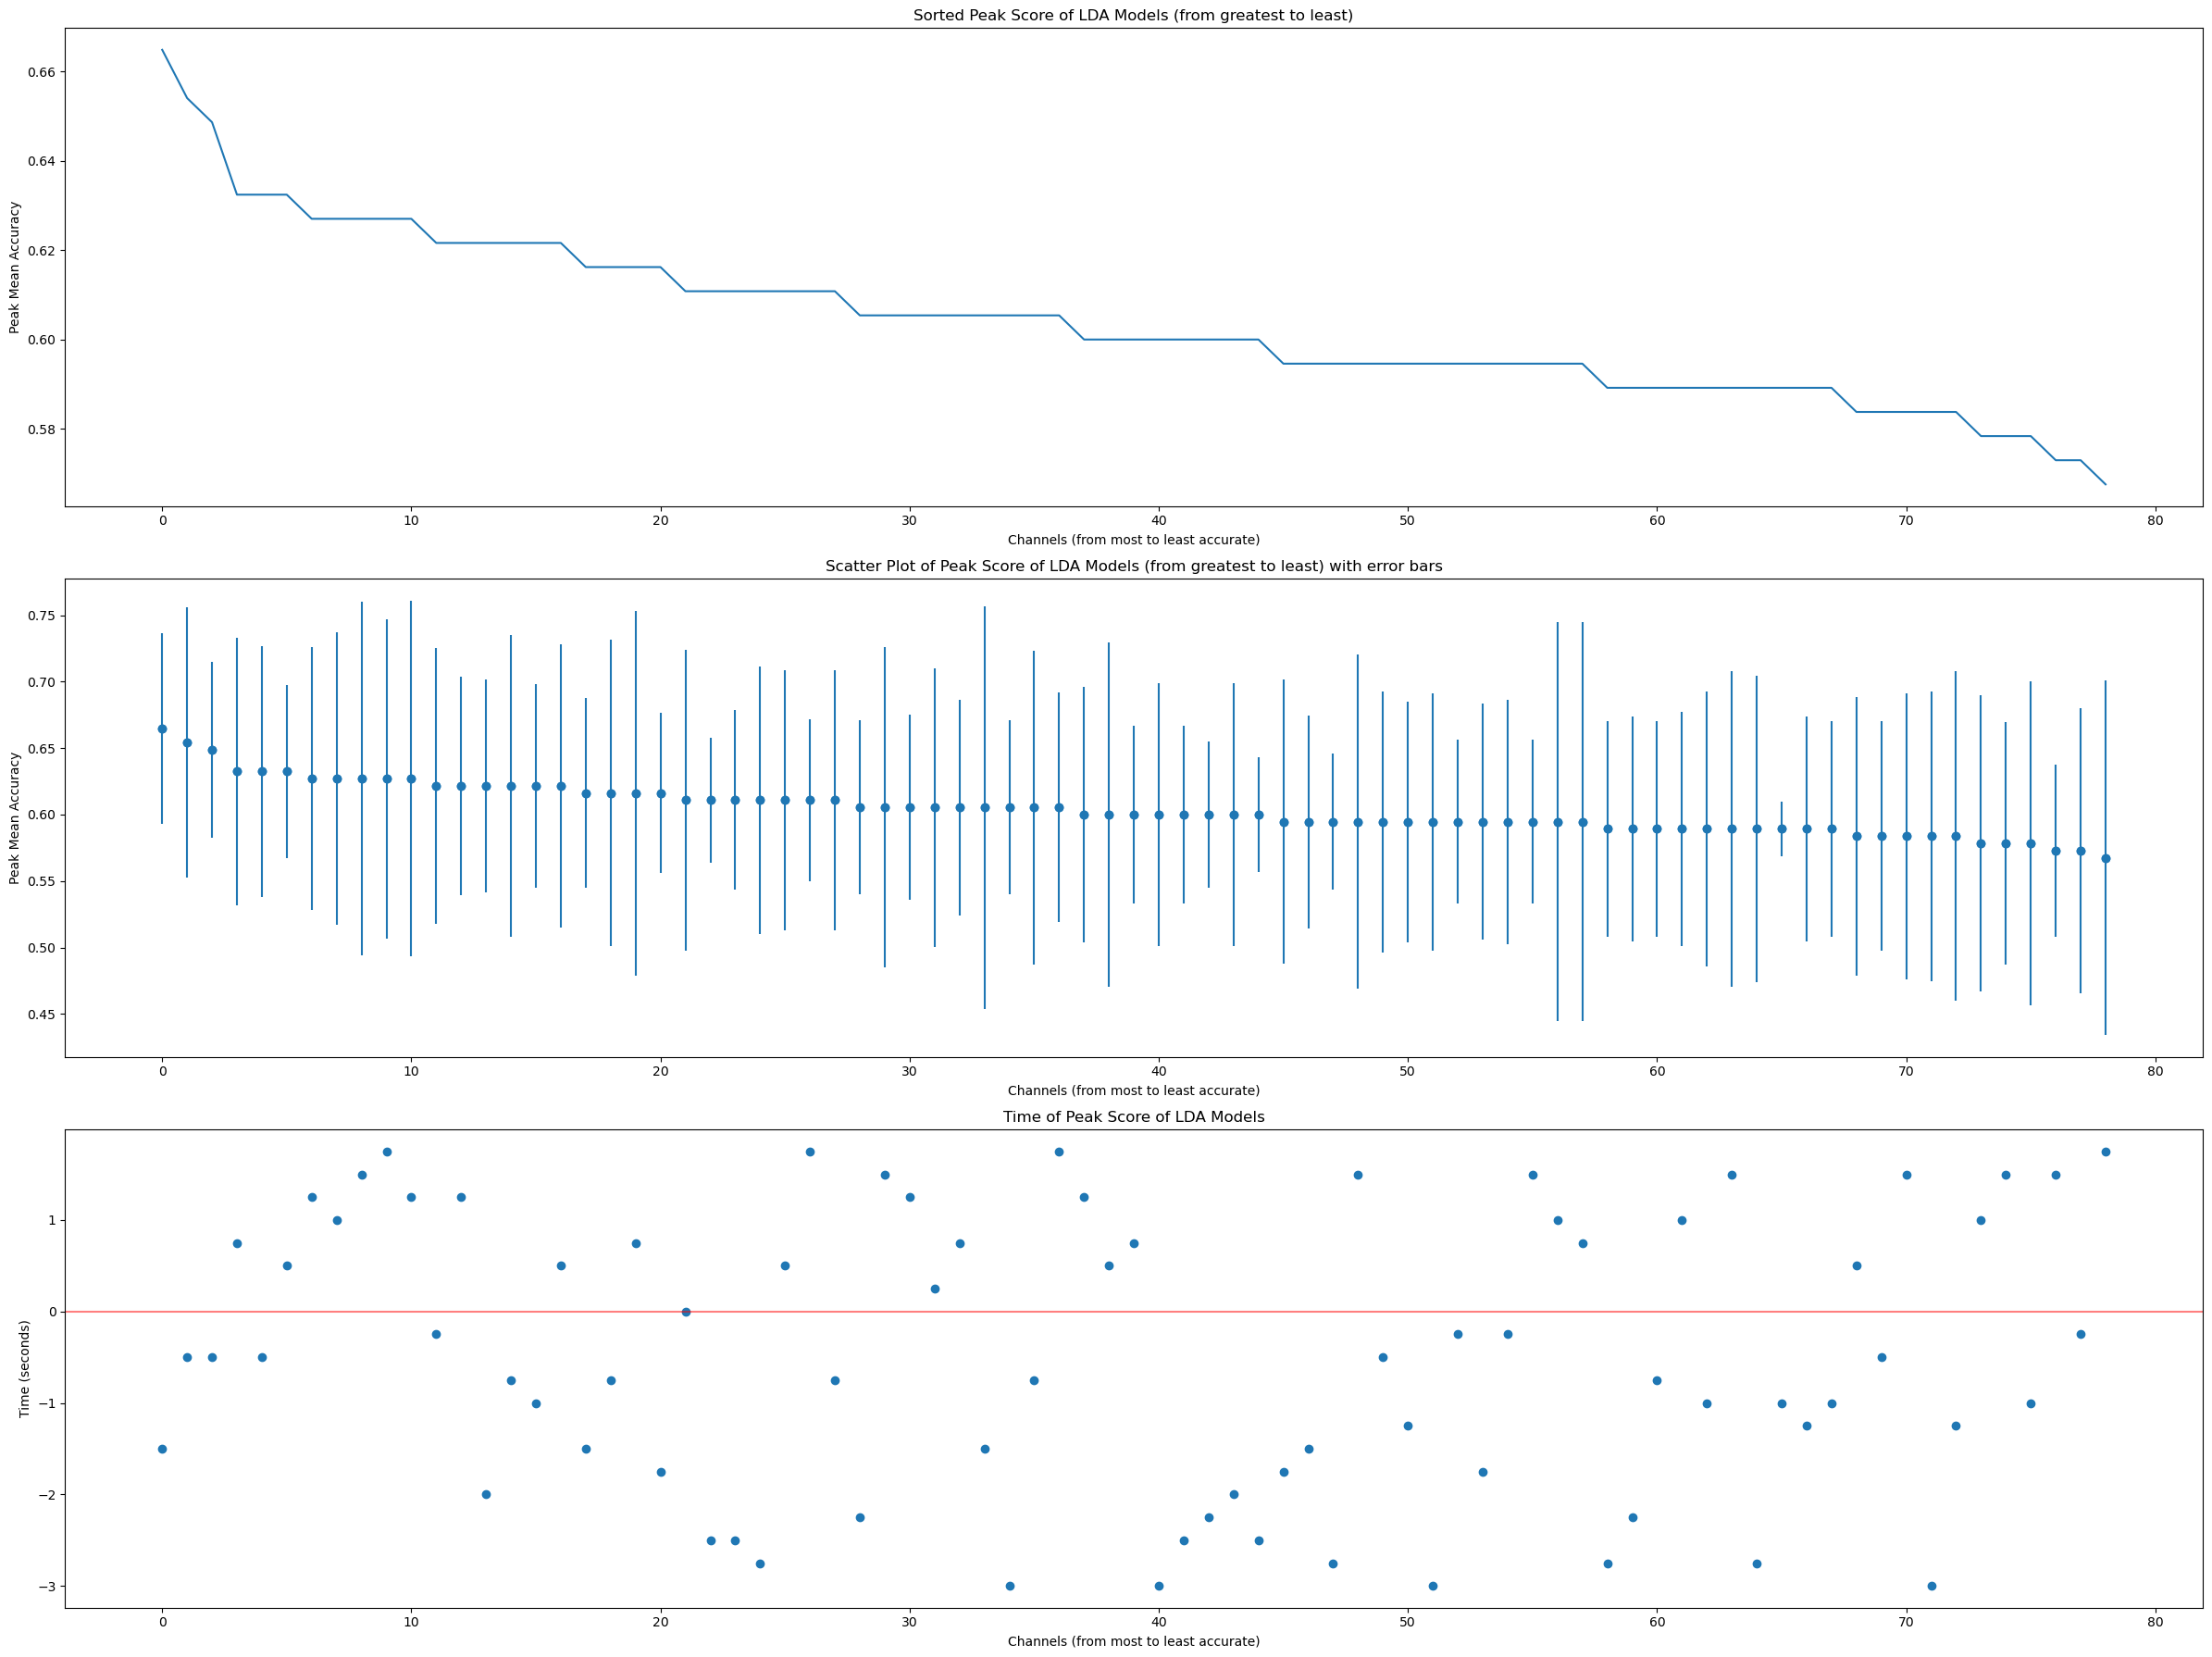

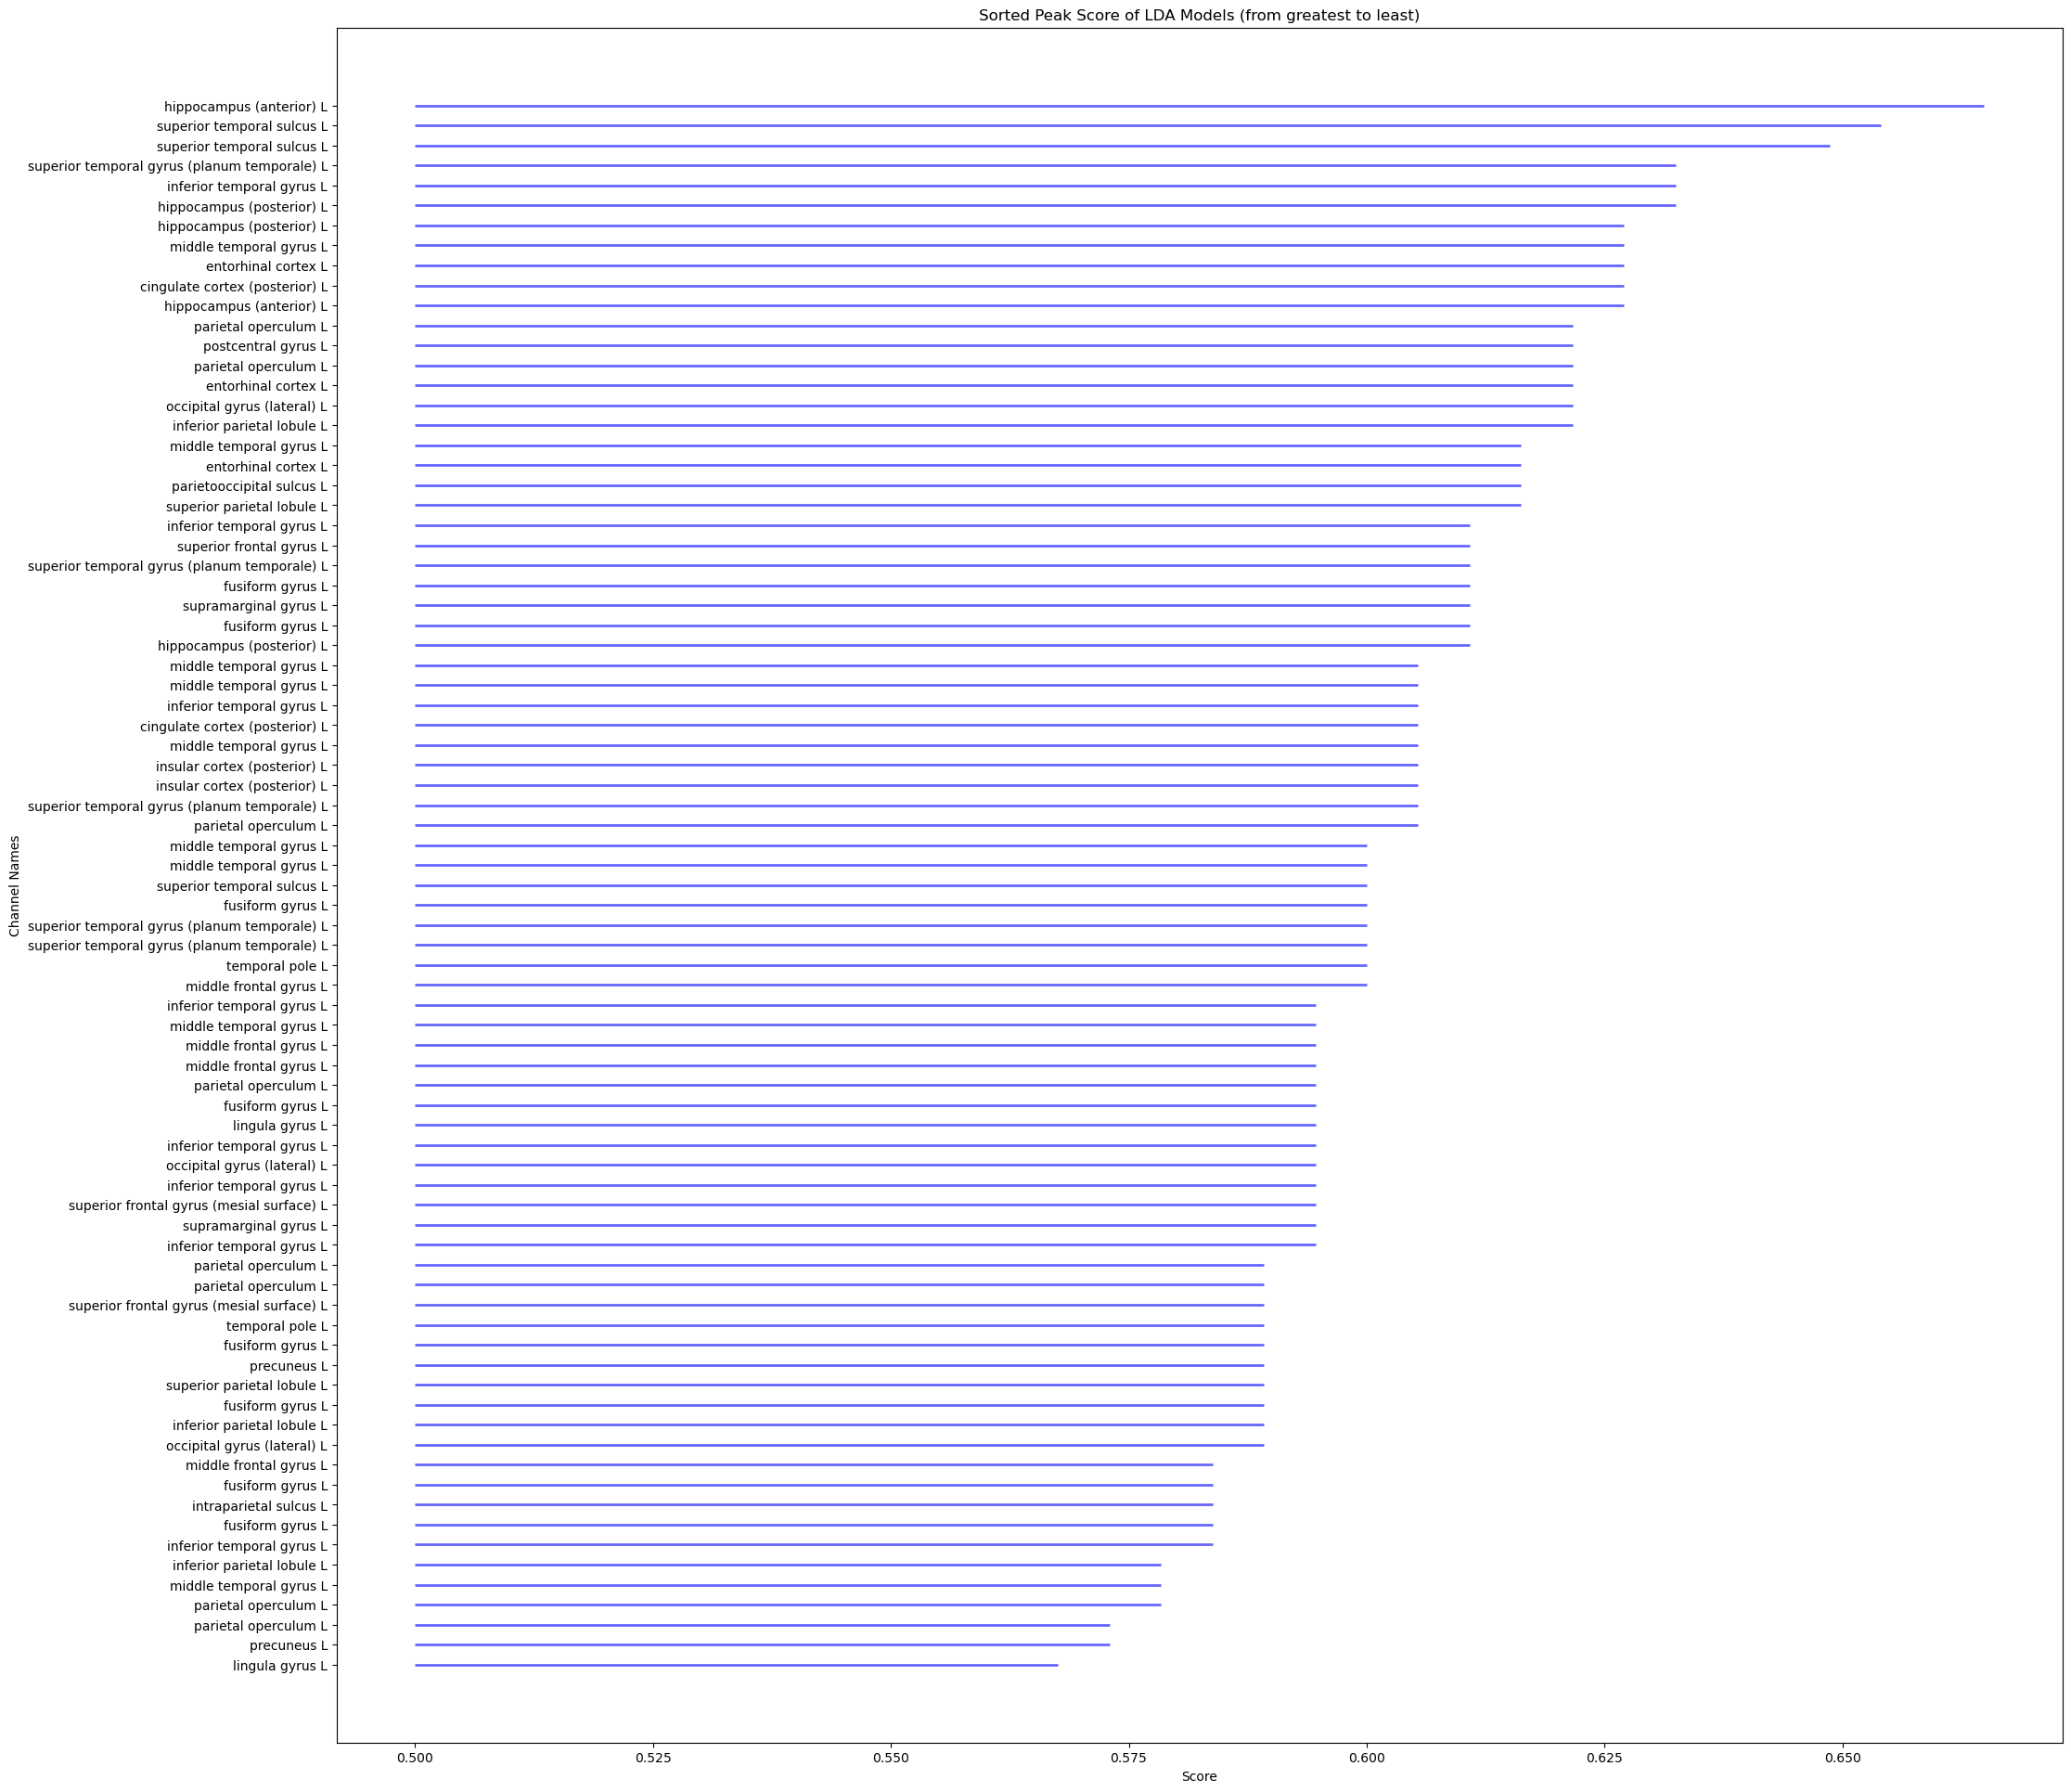

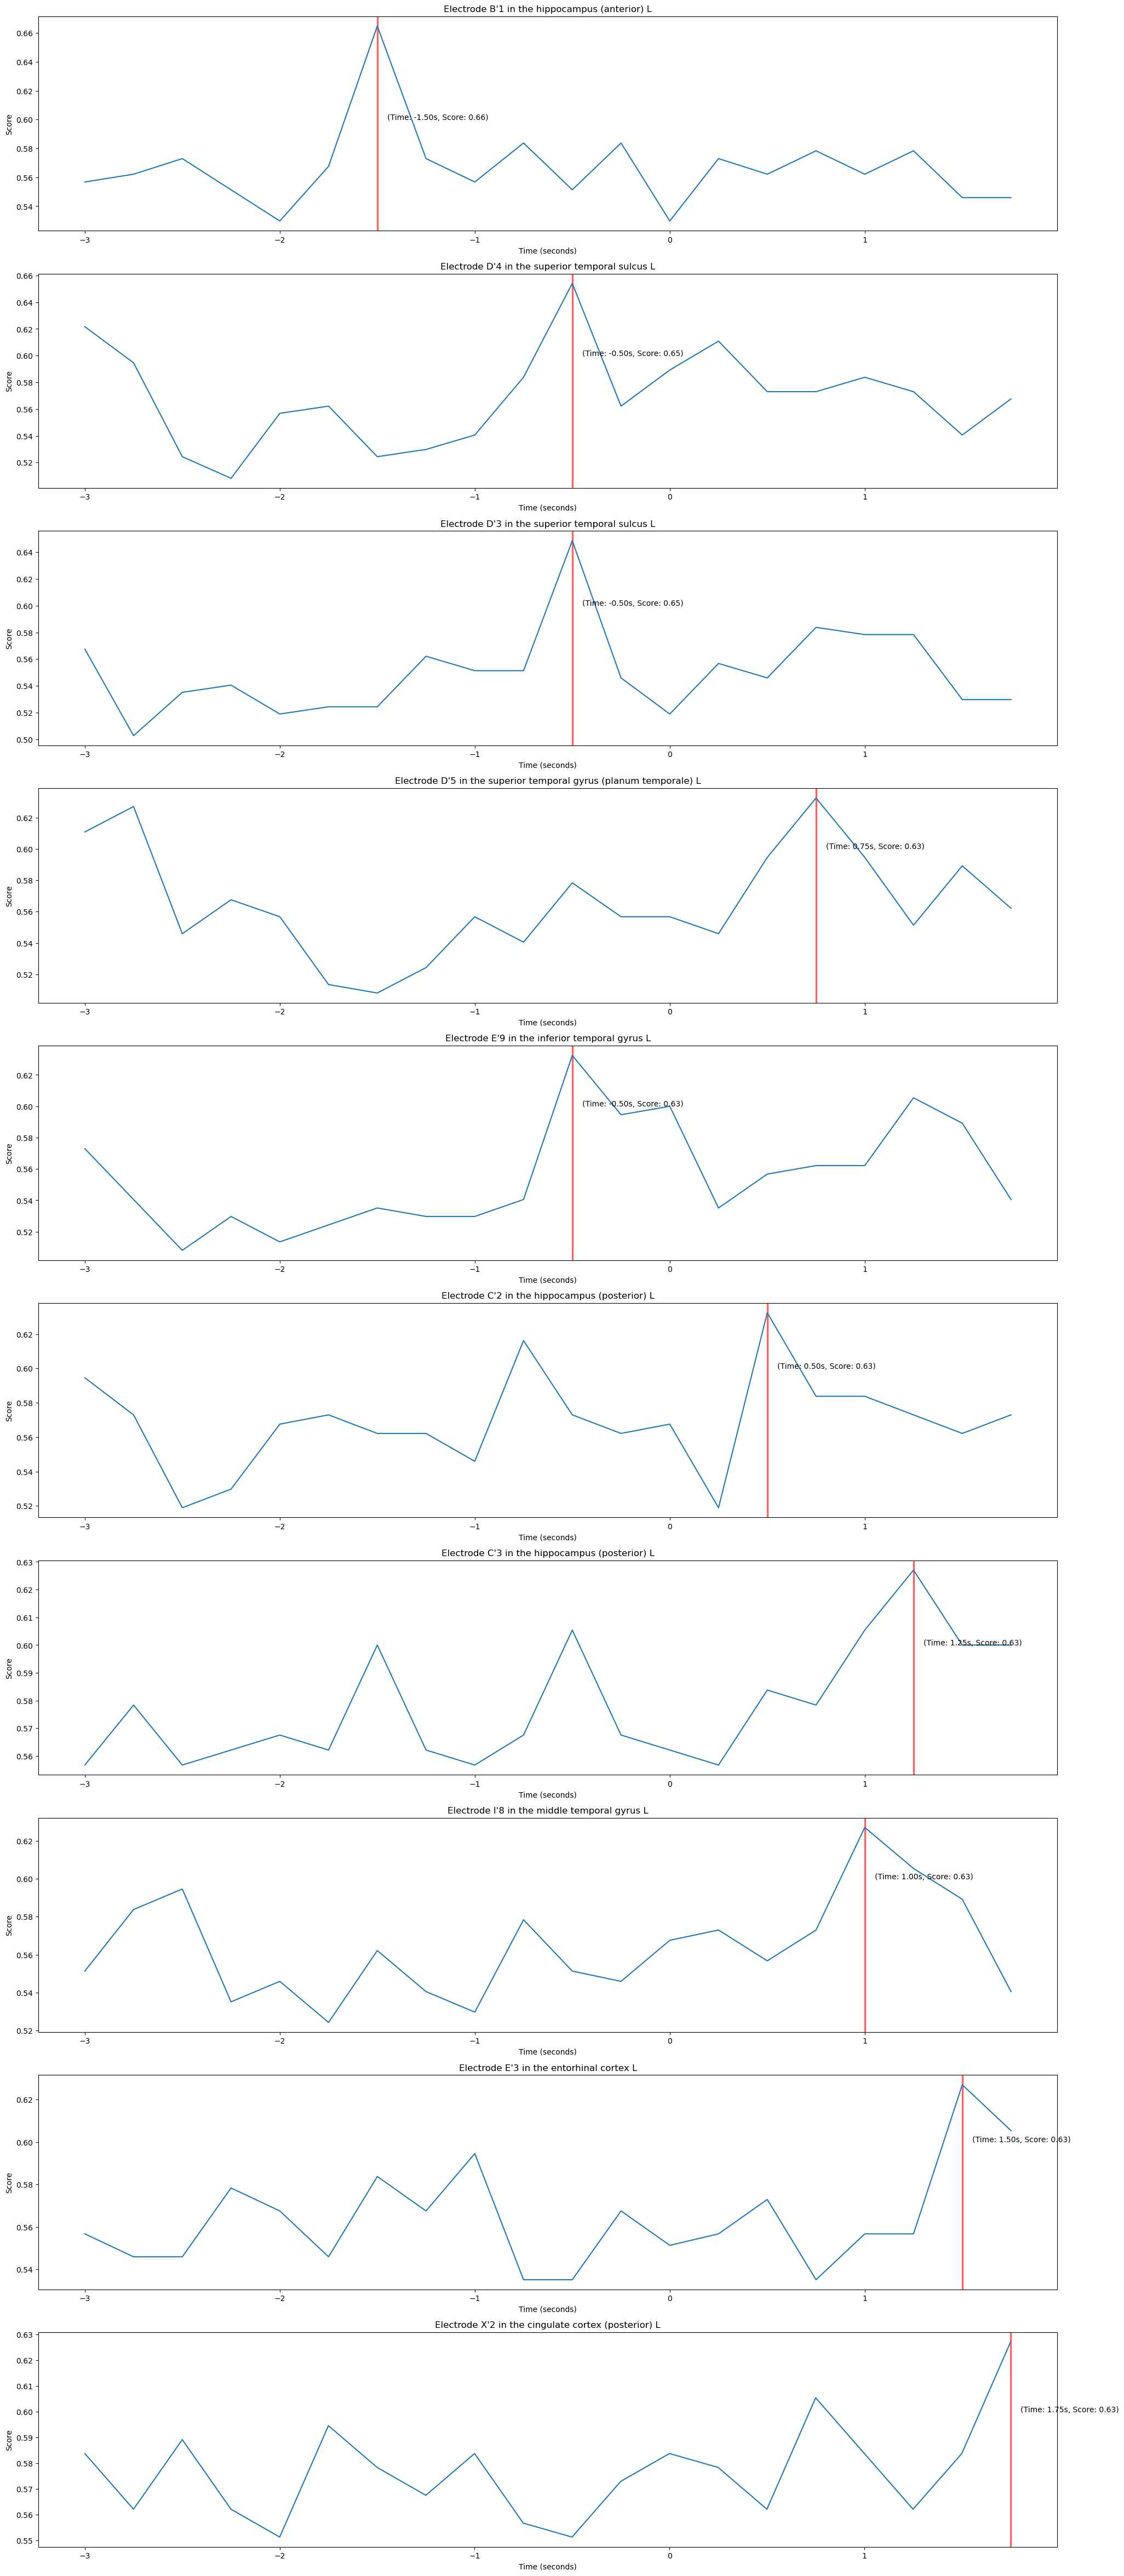

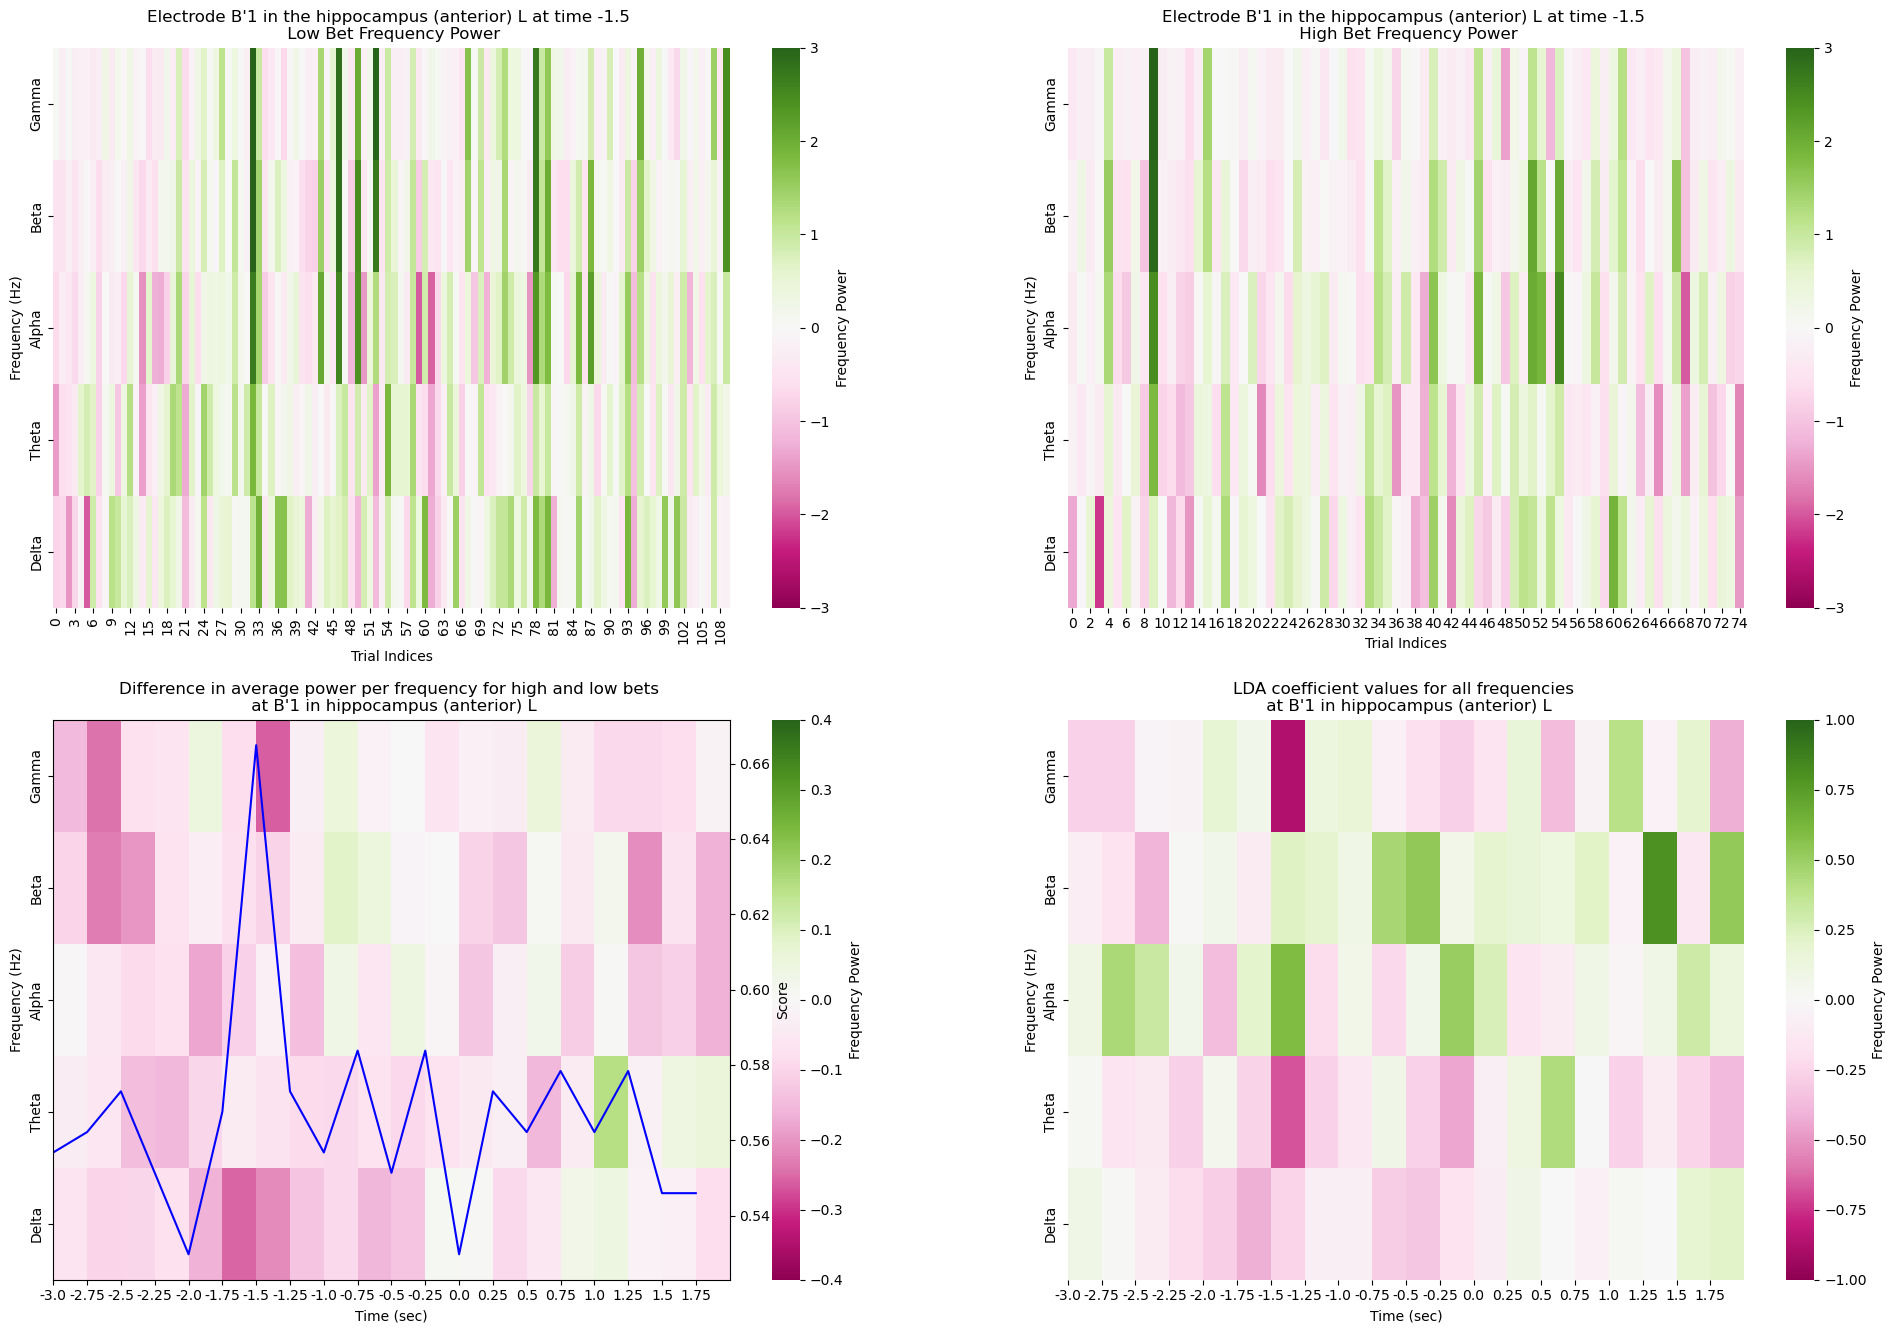

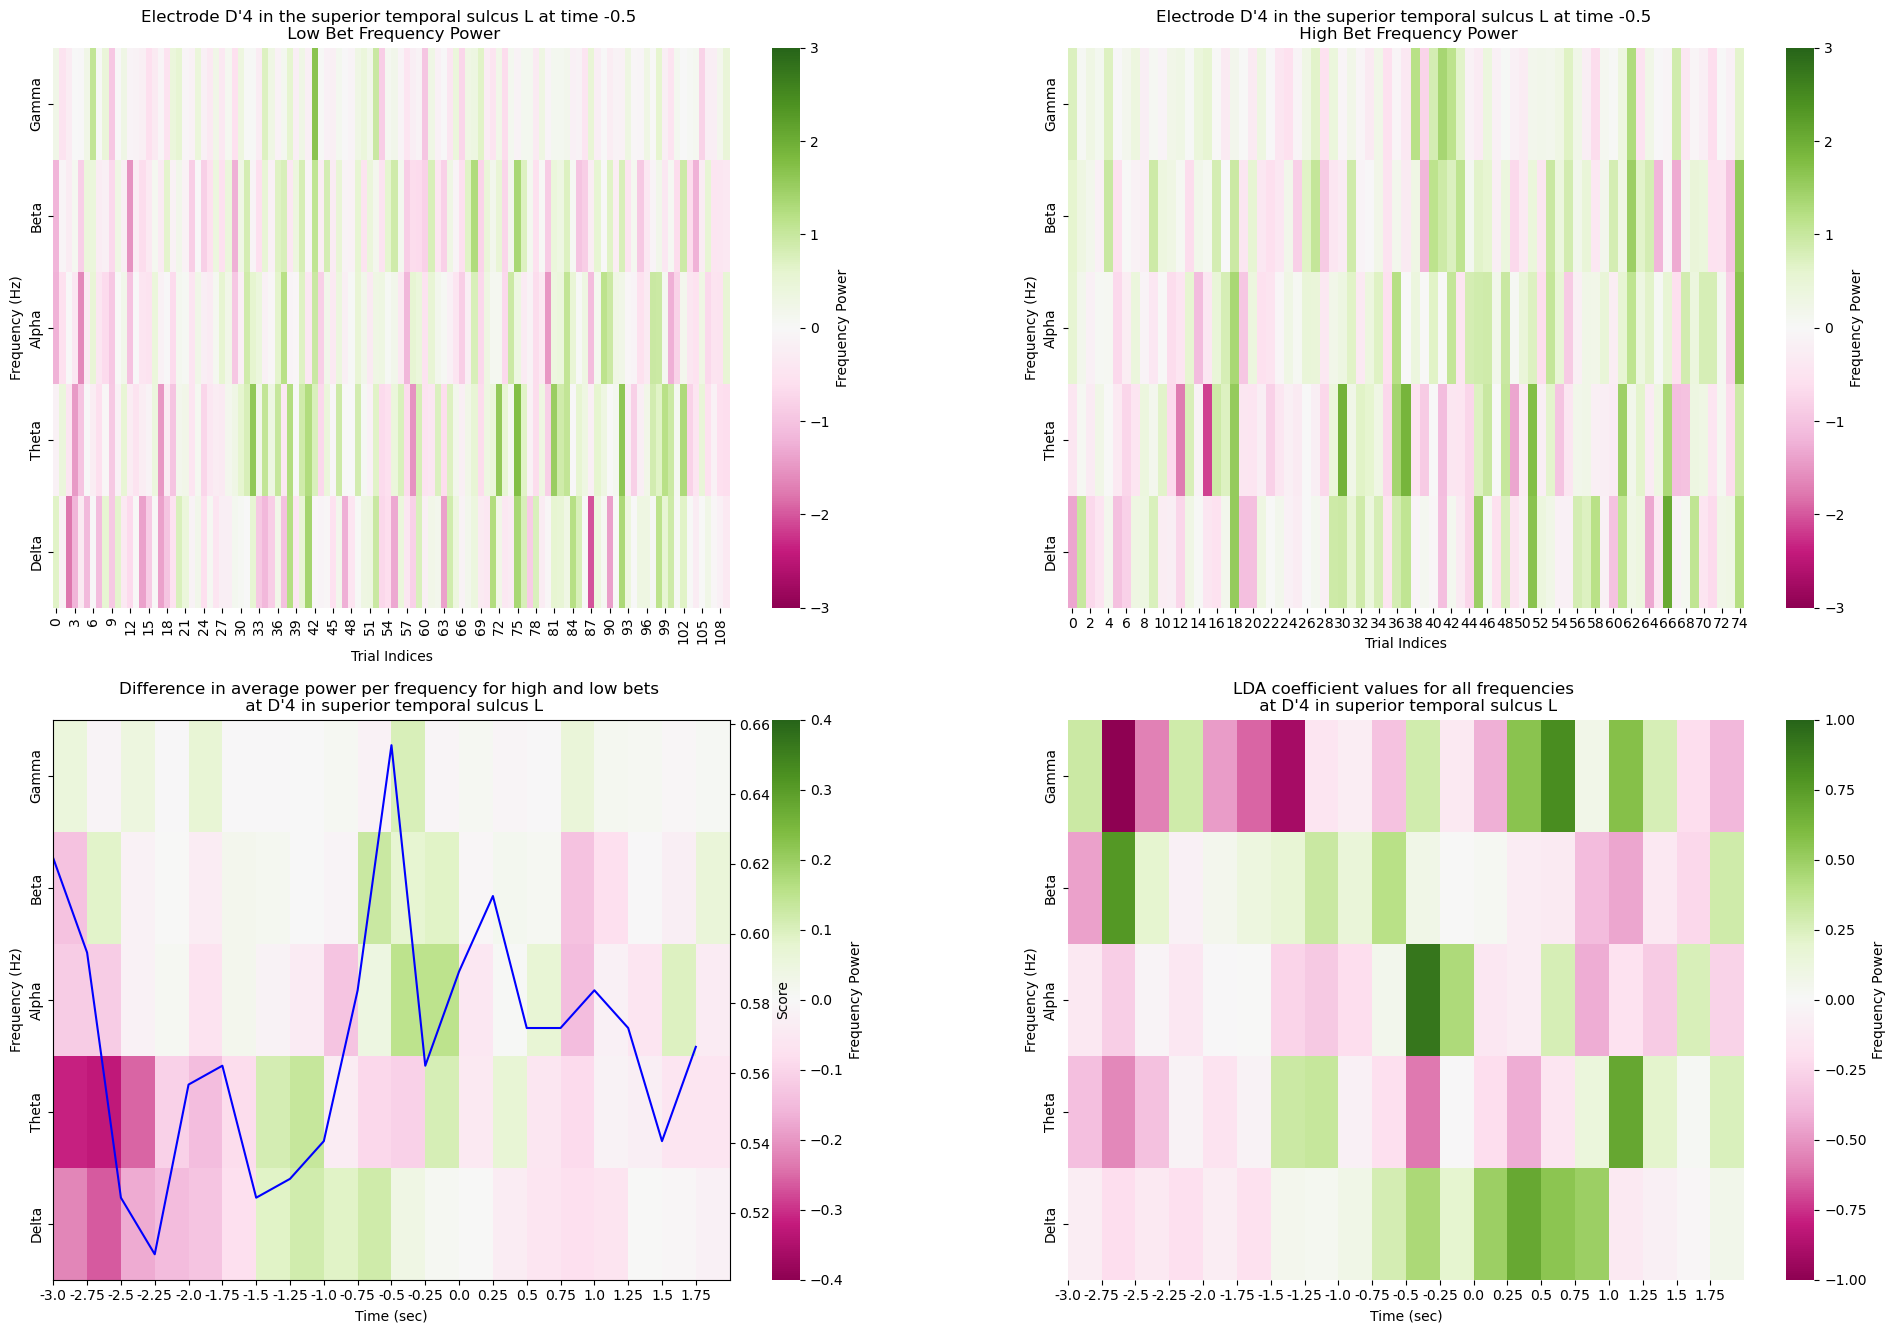

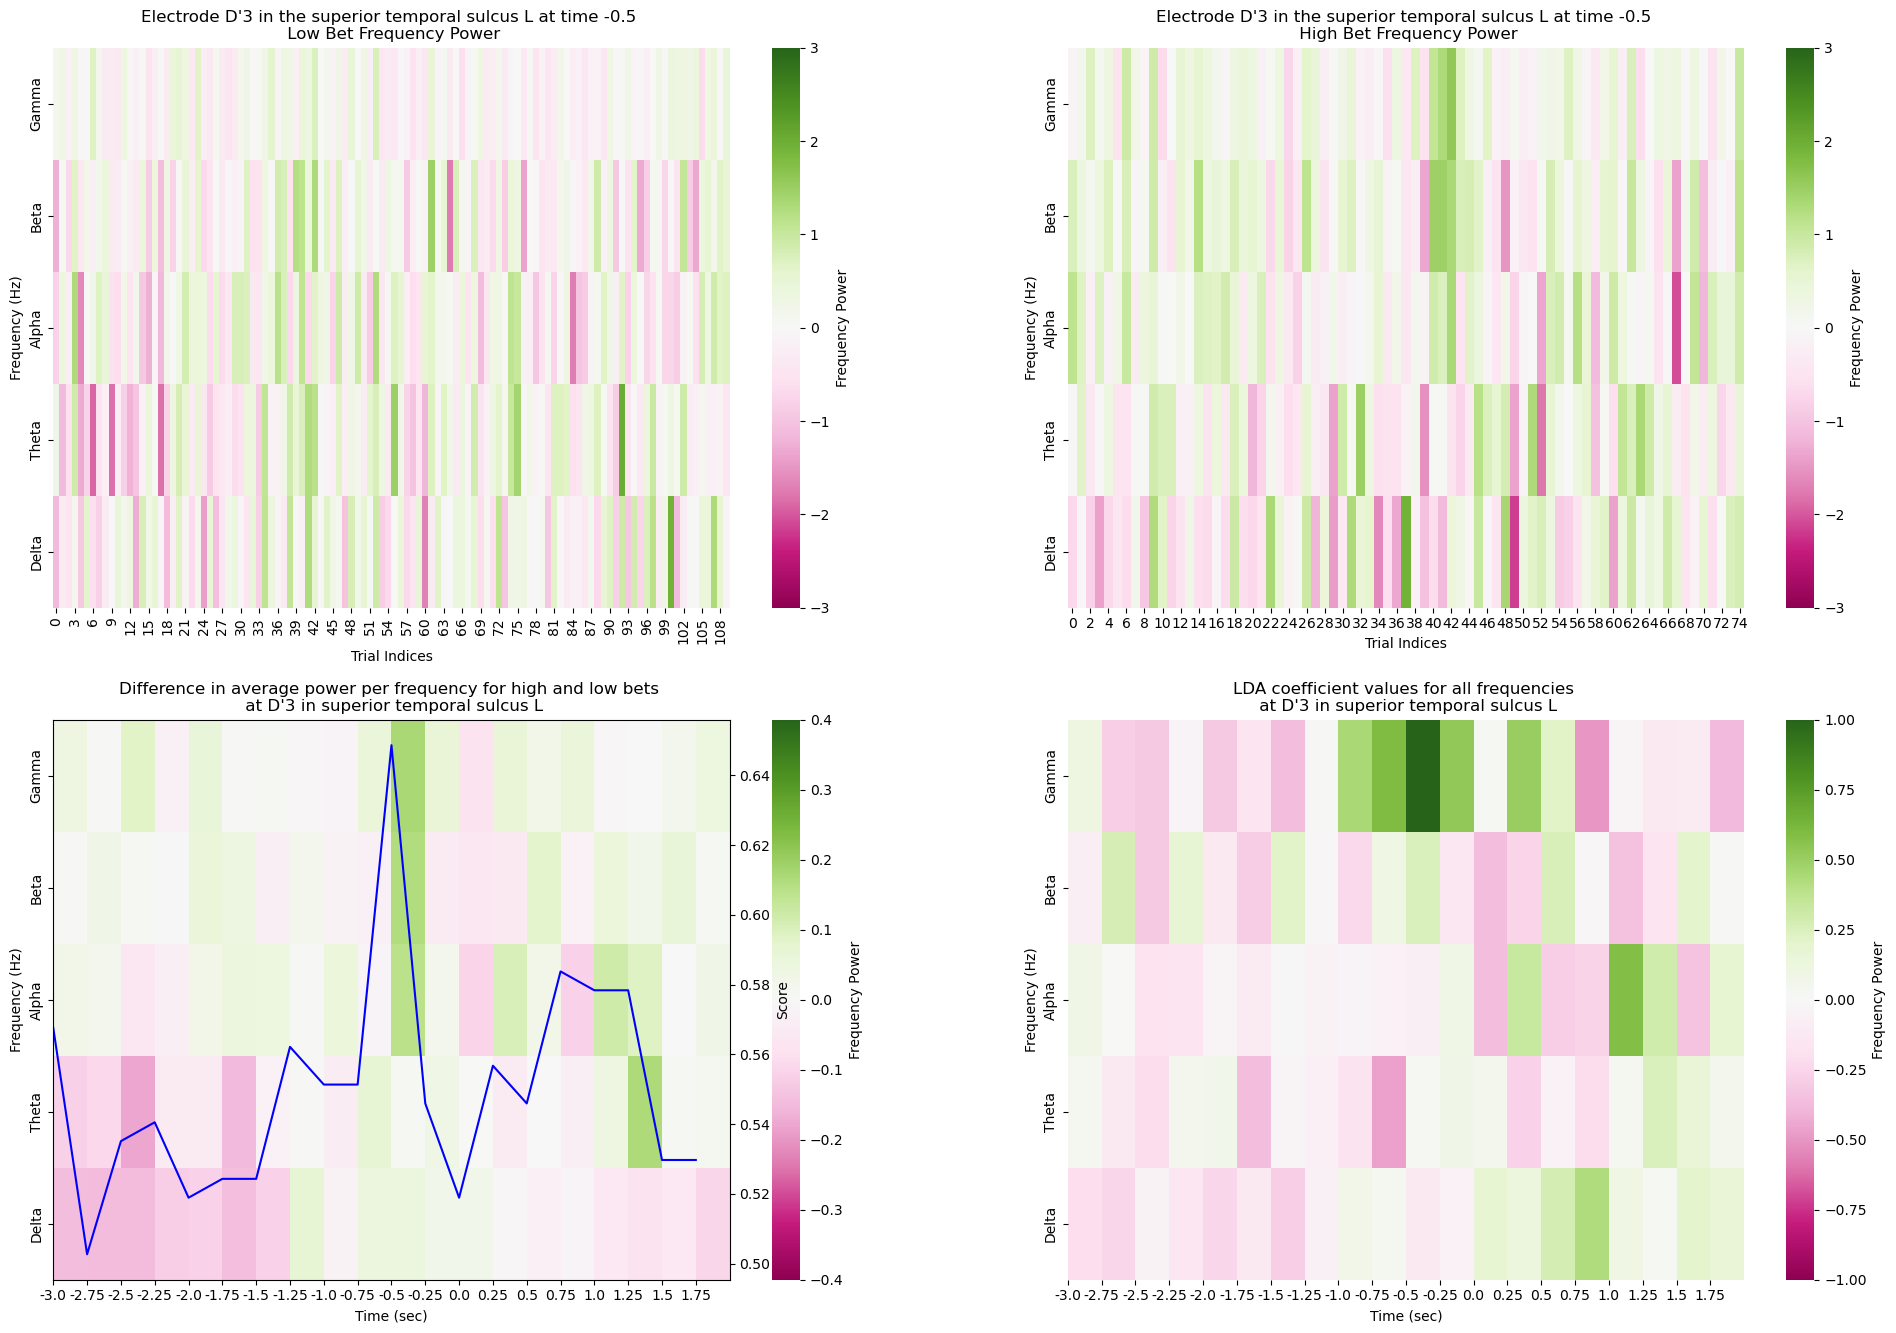

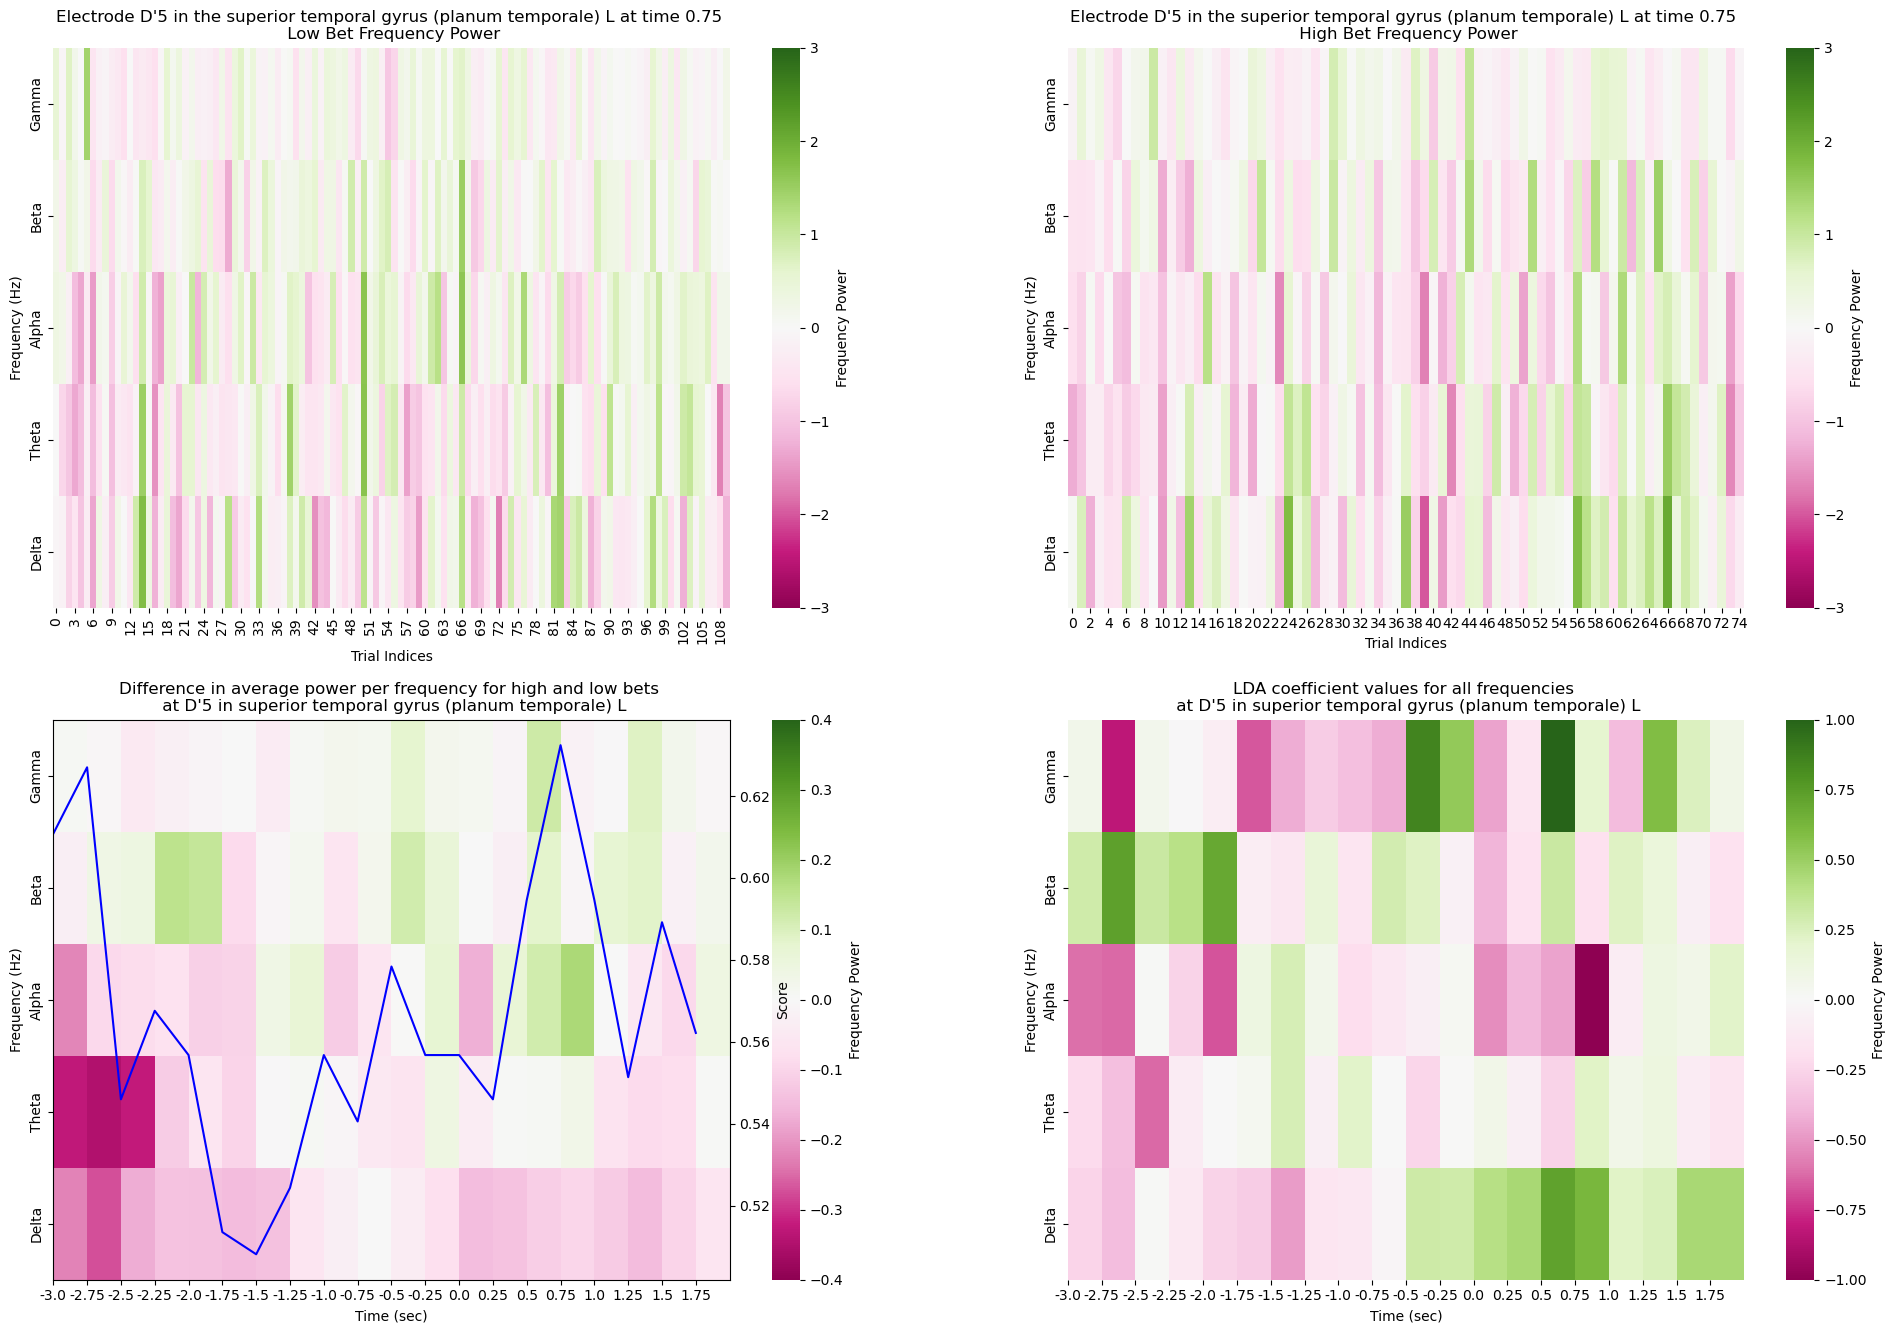

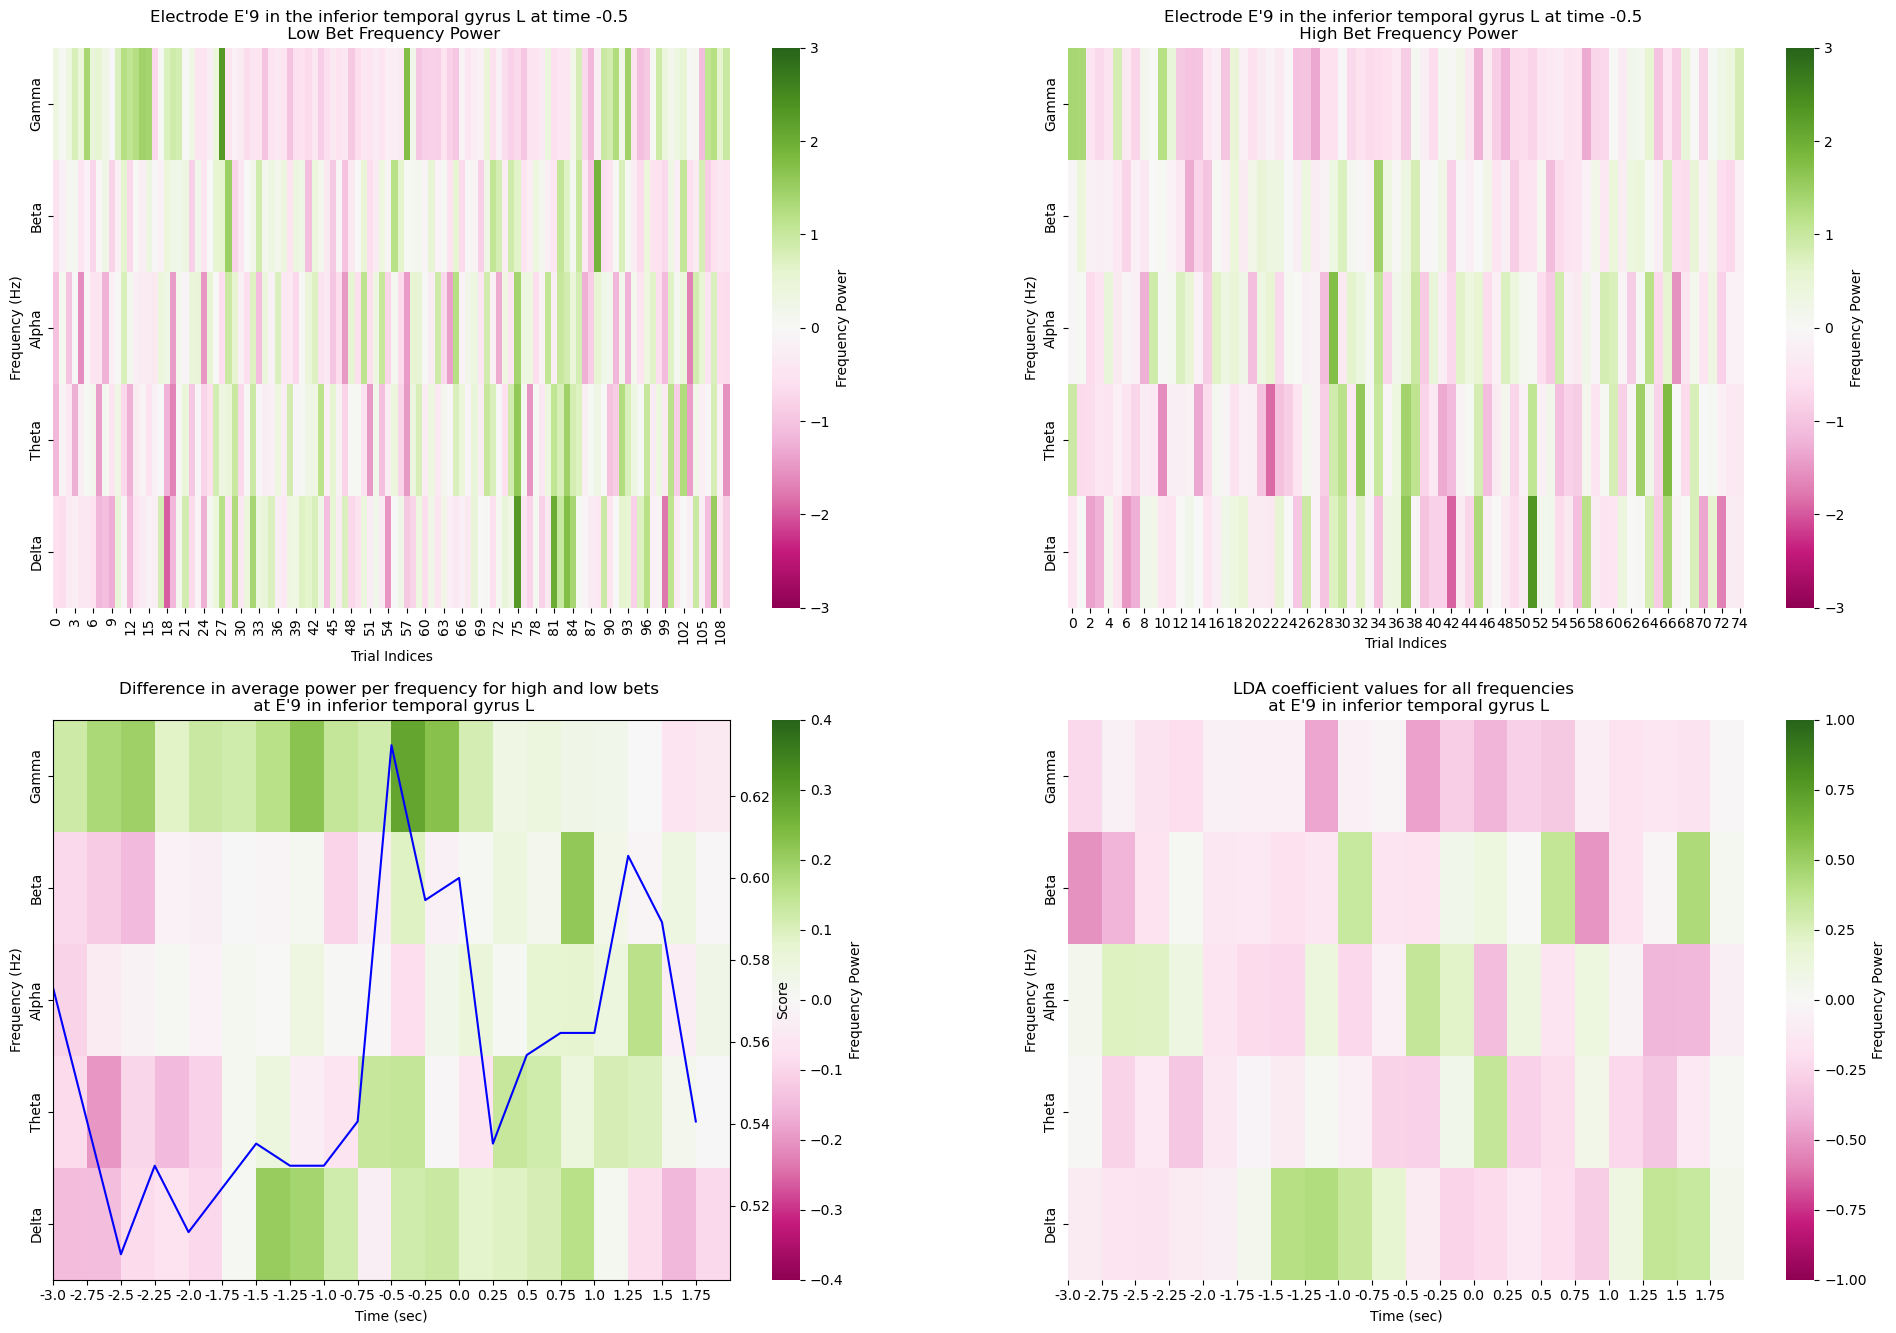

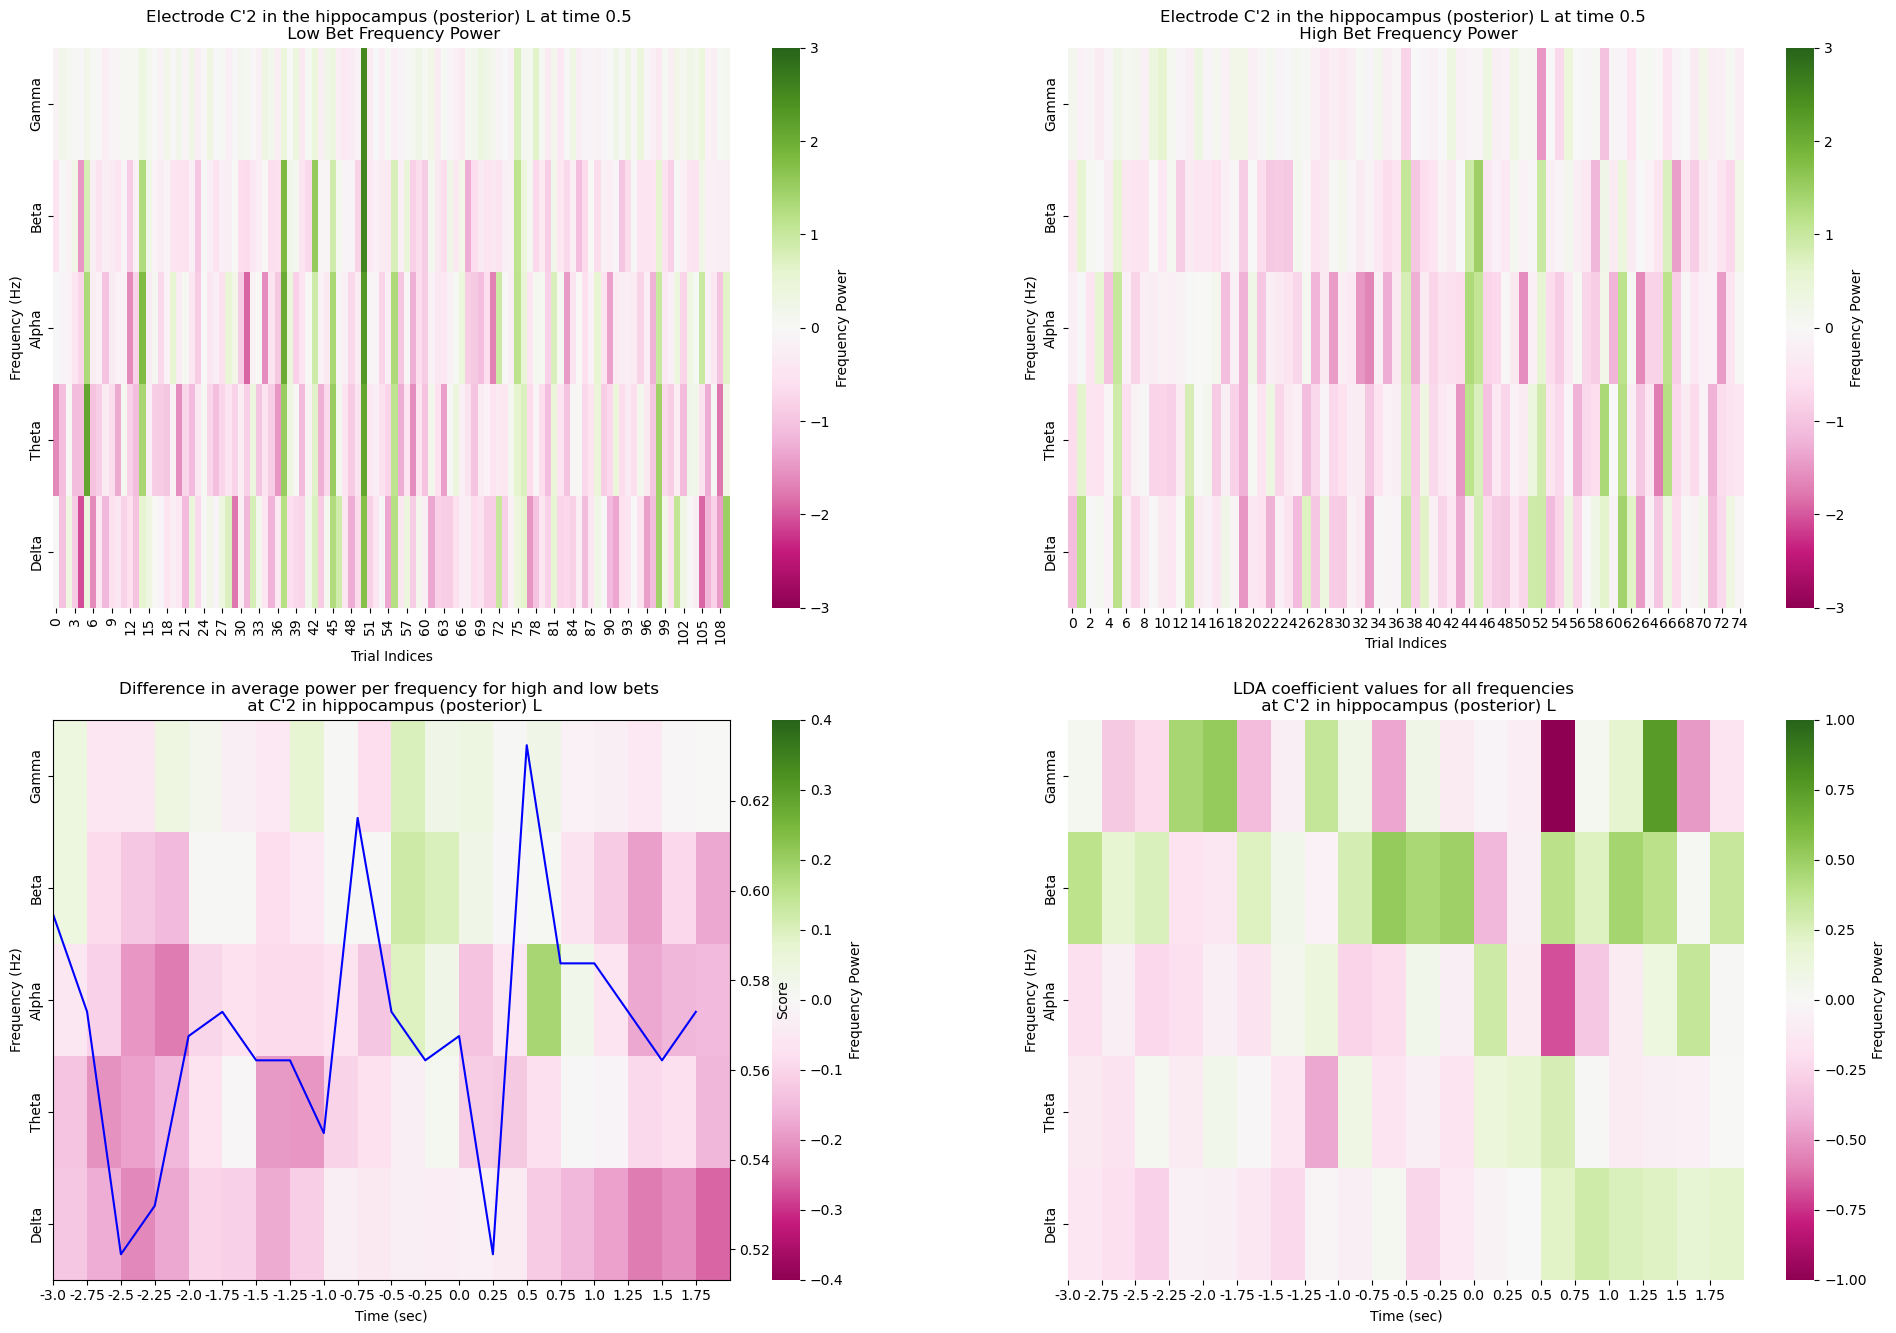

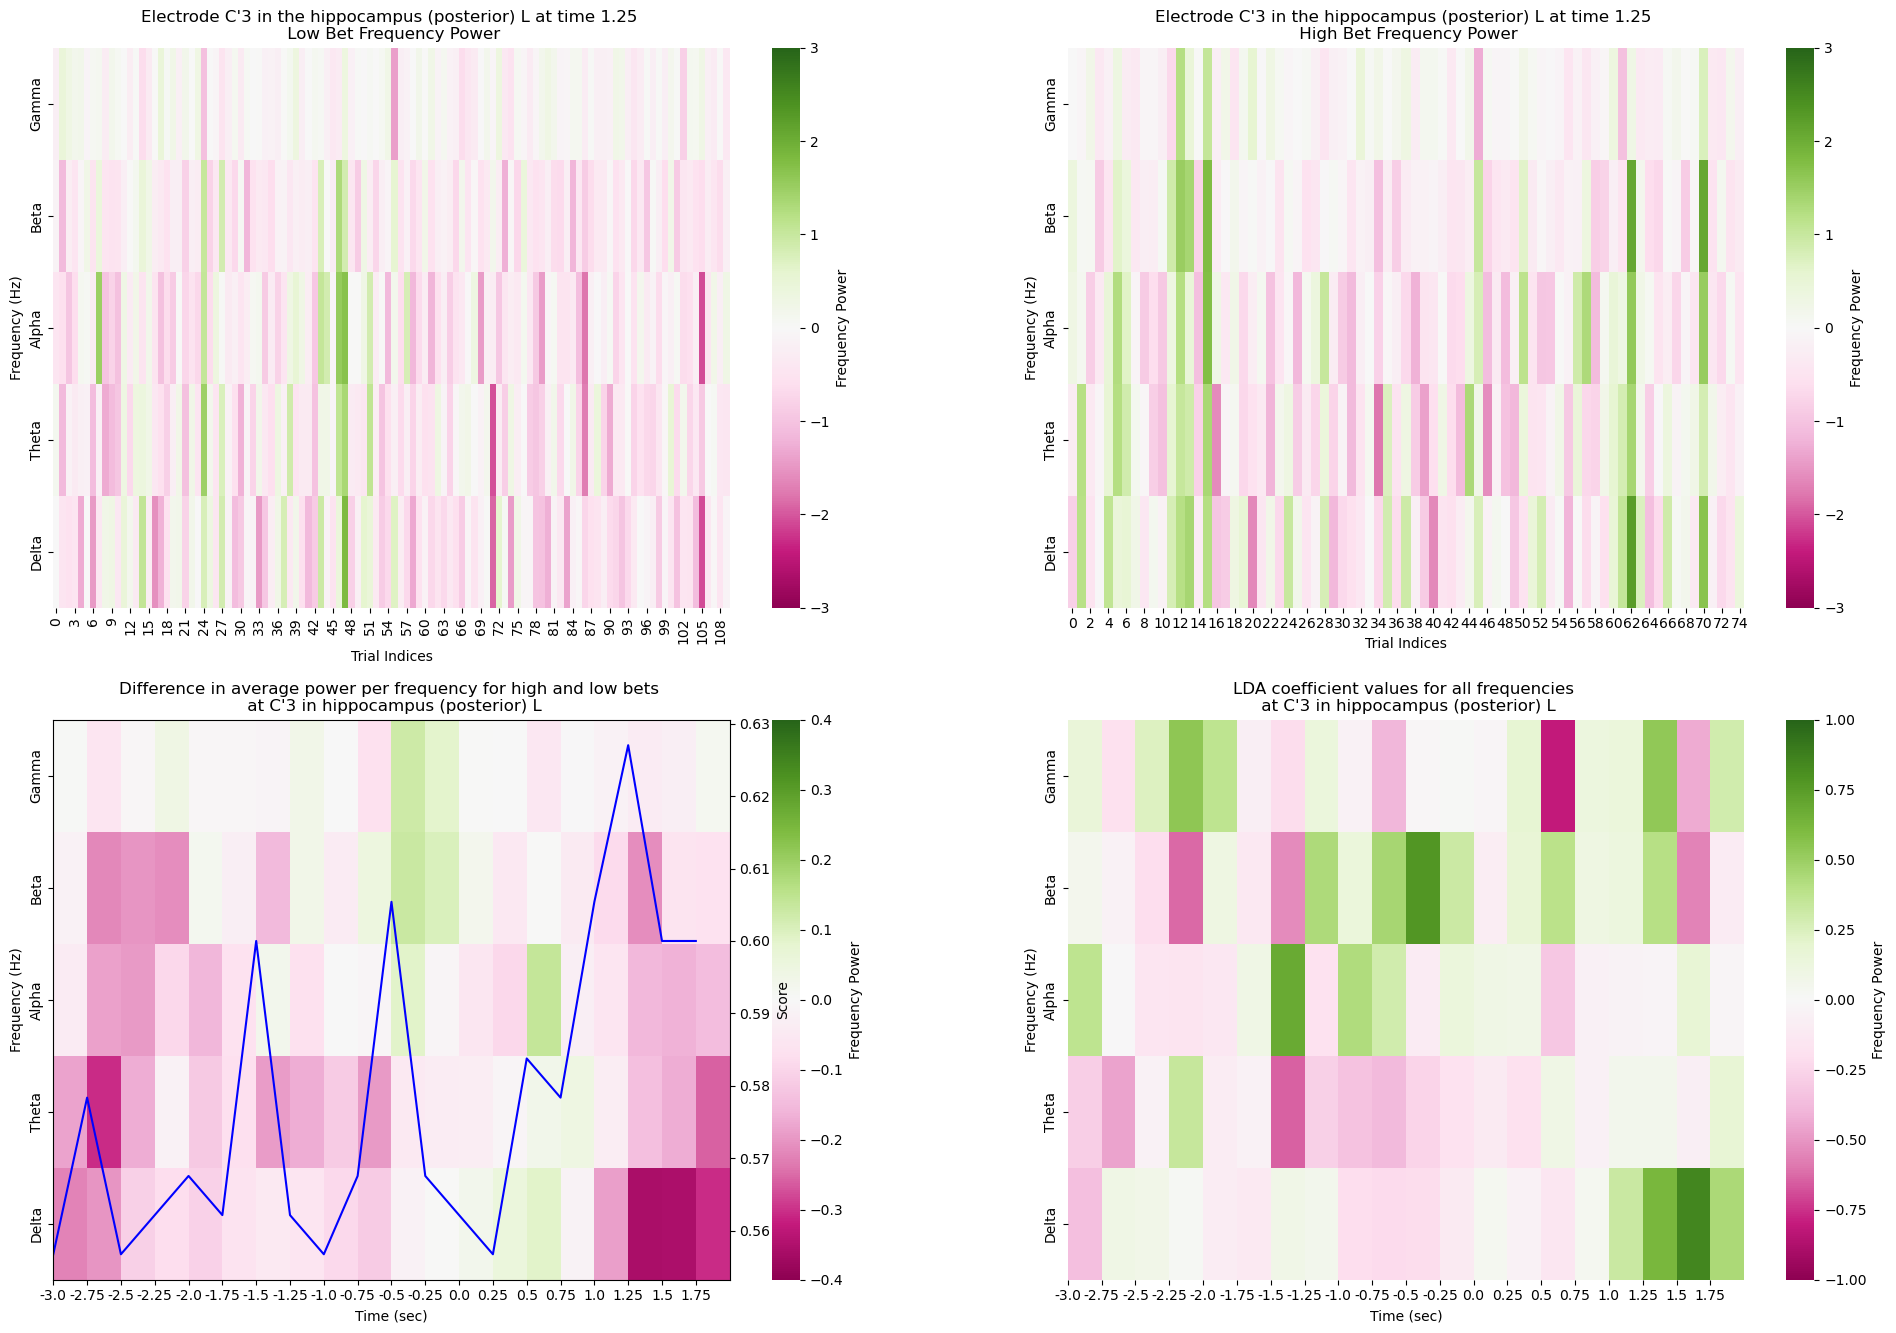

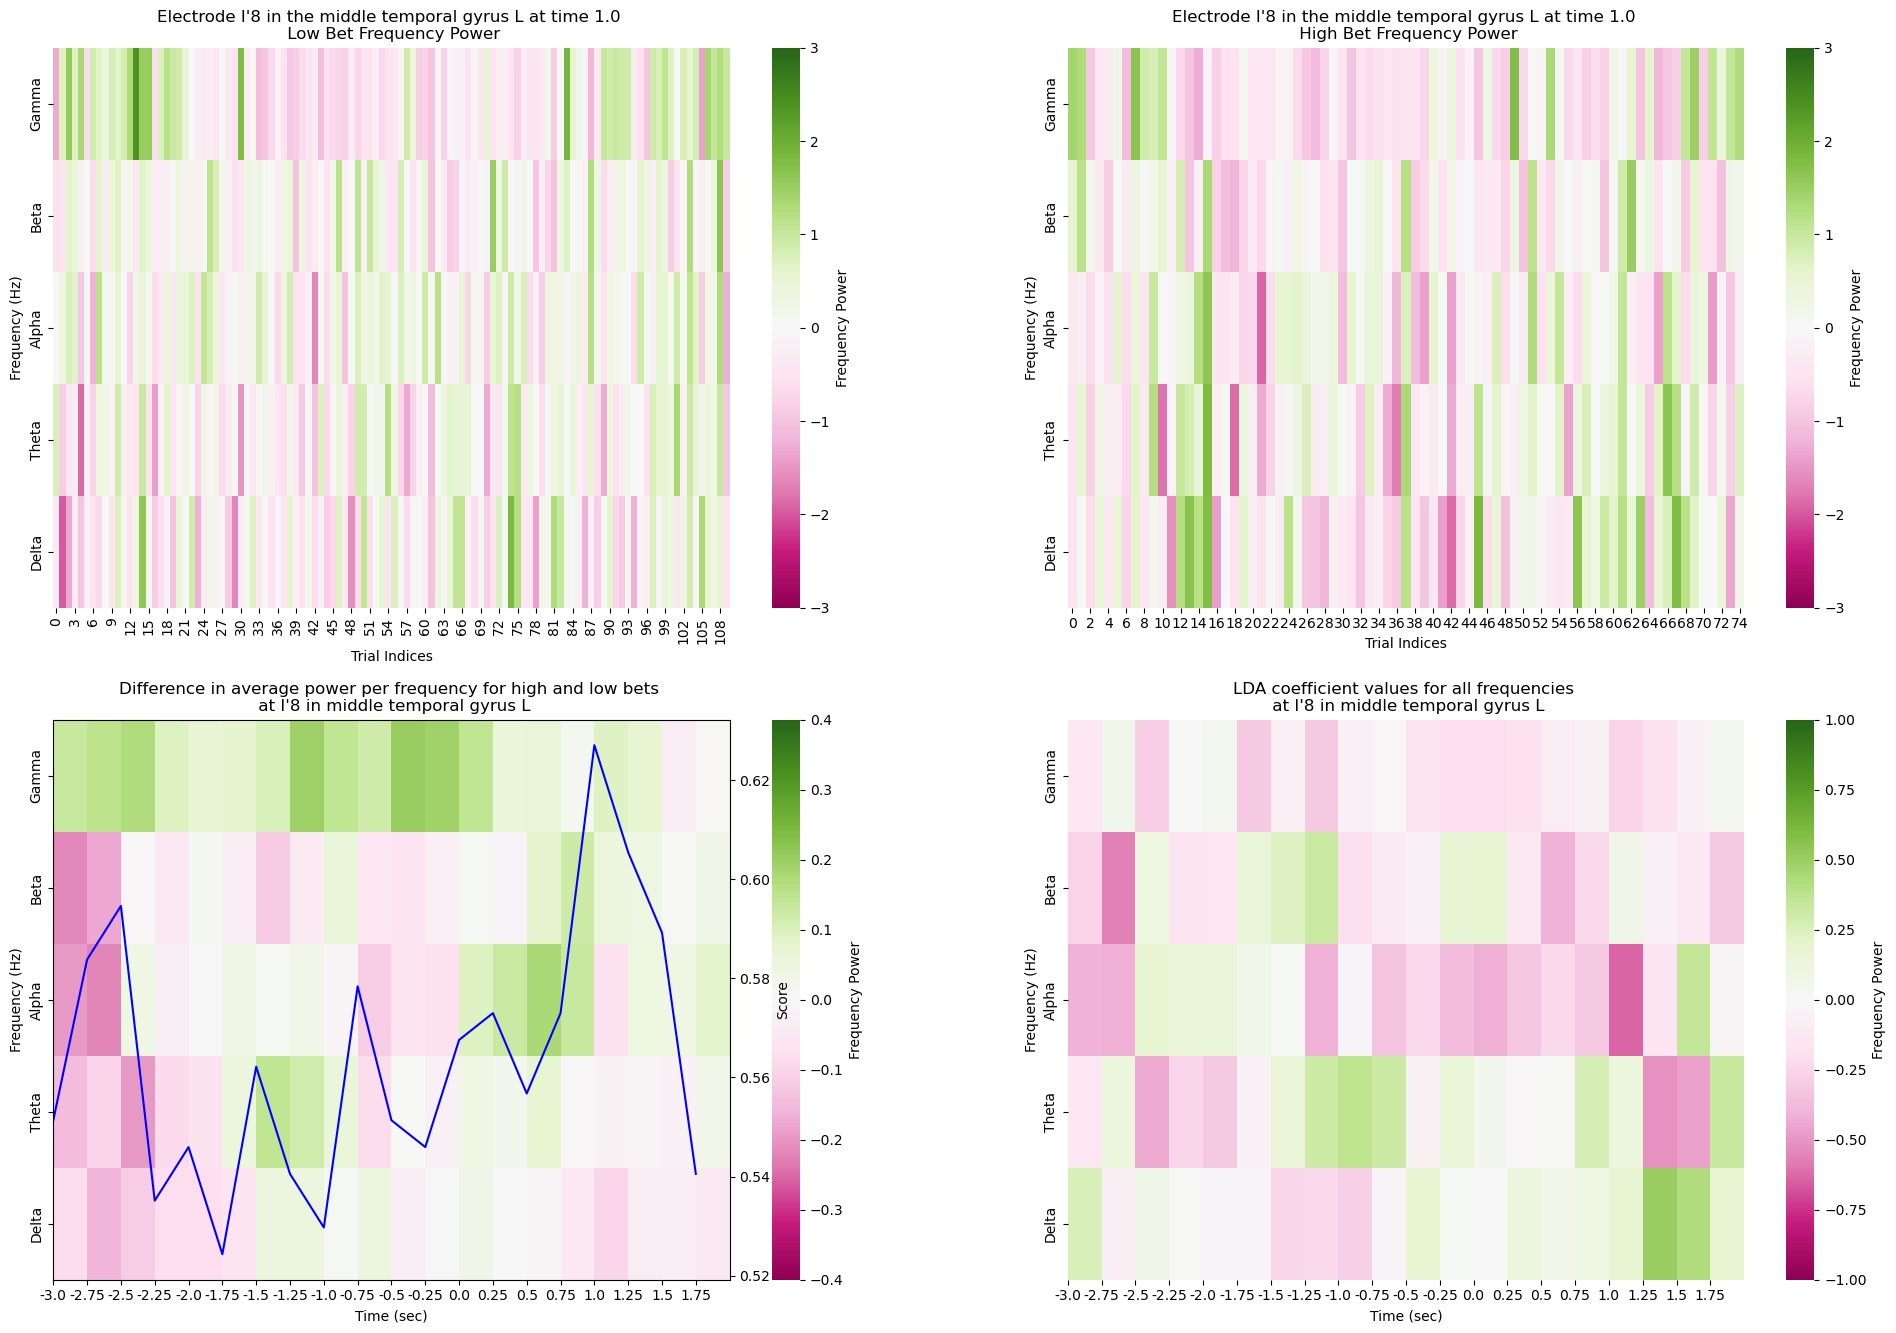

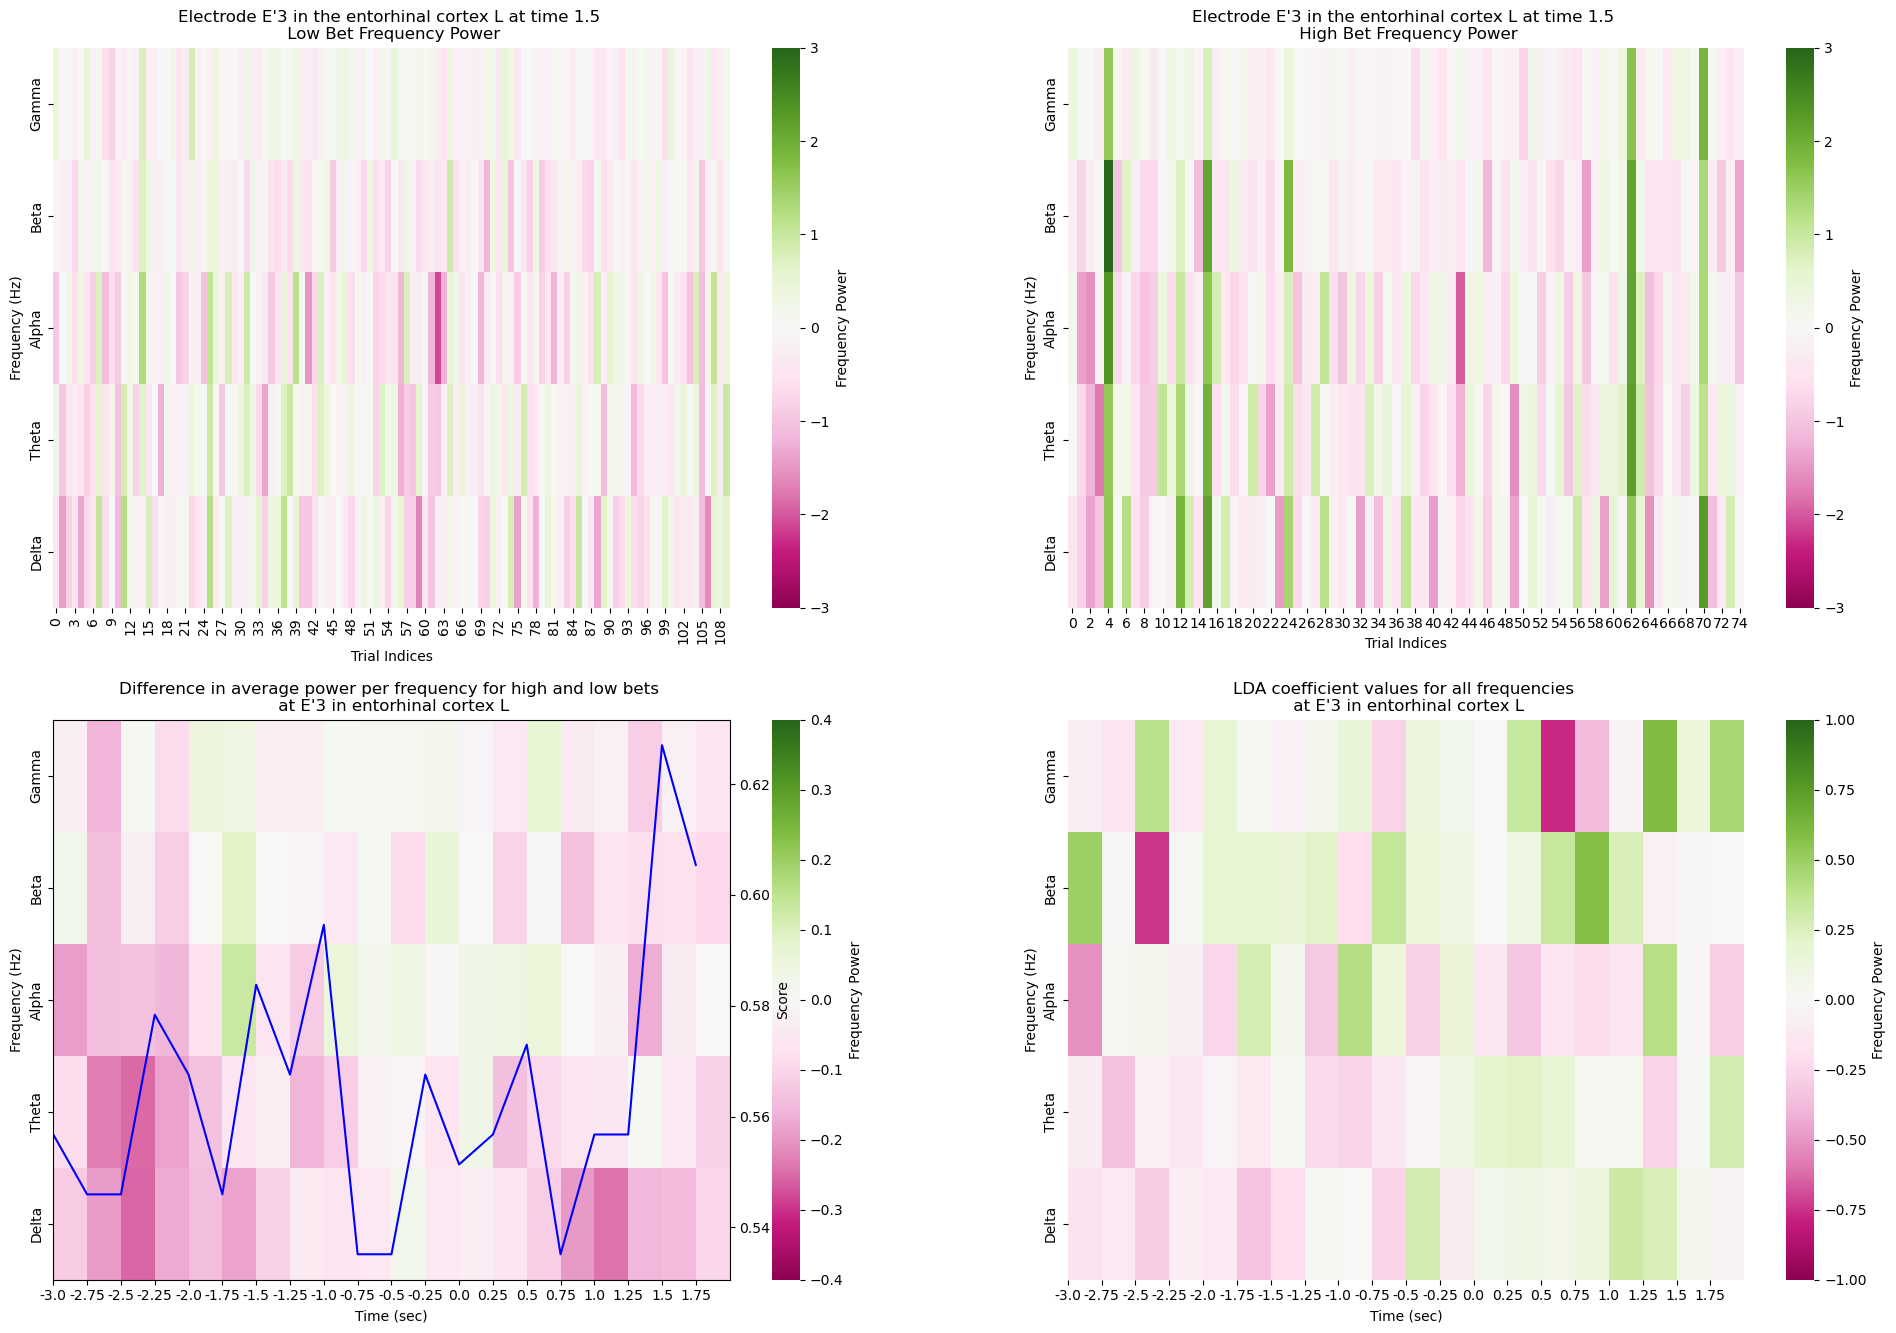

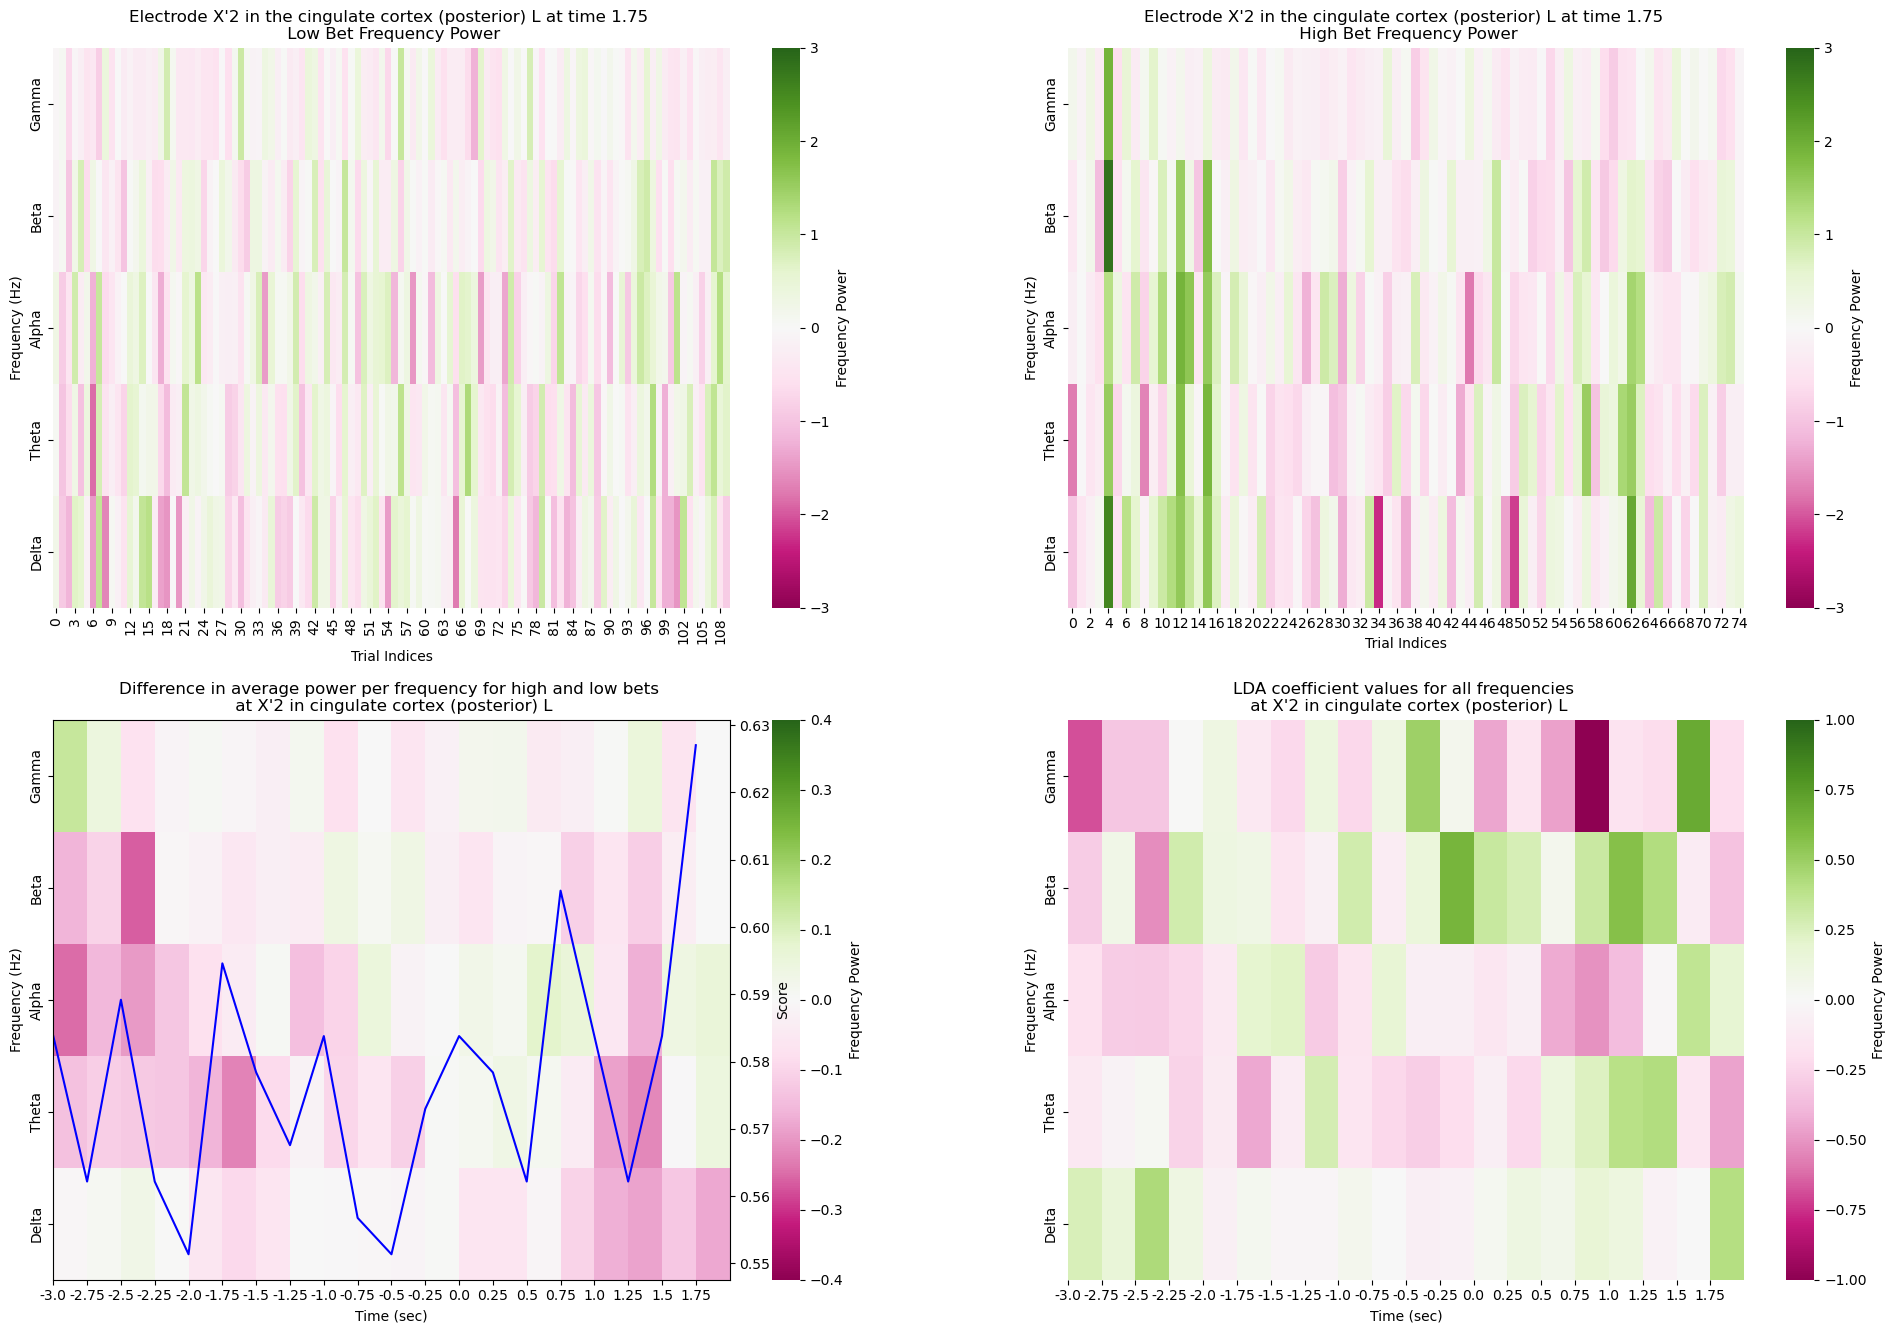

In [28]:
plot_scores(f_band_data, metrics, elec_names, elec_areas, num_channels= 10, filter_channels=True, out_path_plots=out_path_plots)

### Save Plots

In [20]:
mean_scores_max_sorted, elec_names_sorted, elec_areas_sorted = sort_scores(data,metrics, elec_names, elec_areas, filter_channels=True)

sorted_scores = {
    'Sorted Max Scores' : mean_scores_max_sorted[:,2],
    'Sorted Electrode Names' : elec_names_sorted,
    'Sorted Electrode Areas' : elec_areas_sorted
}

In [21]:
with open(out_path_metrics+'_sorted_scores.csv', 'w', newline="") as fp:
    writer = csv.DictWriter(fp, fieldnames=sorted_scores.keys())
    writer.writeheader()
    writer.writerow(sorted_scores)

# Extraneous Code